In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import UnivariateSpline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.simplefilter('ignore') # 
#from pandarallel import pandarallel

In [2]:
mortgage_activity = pd.read_pickle('mortgage_activity.pickle')

## The Bin-Scatter Plot of Cap Rate vs NOI for Affordable vs Non-Affordable Mortgages

In [3]:
# Generate 'Affordable Housing Indicator' based on 'Affordable Housing Type' being not NaN
mortgage_activity['Affordable Housing Indicator'] = np.where(
    mortgage_activity['Affordable Housing Type'].notna(), 1, 0
)

# Replace 'Affordable Housing Indicator' with NaN for rows where 'Note Year' is less than 2014
mortgage_activity.loc[mortgage_activity['Note Year'] < 2014, 'Affordable Housing Indicator'] = np.nan

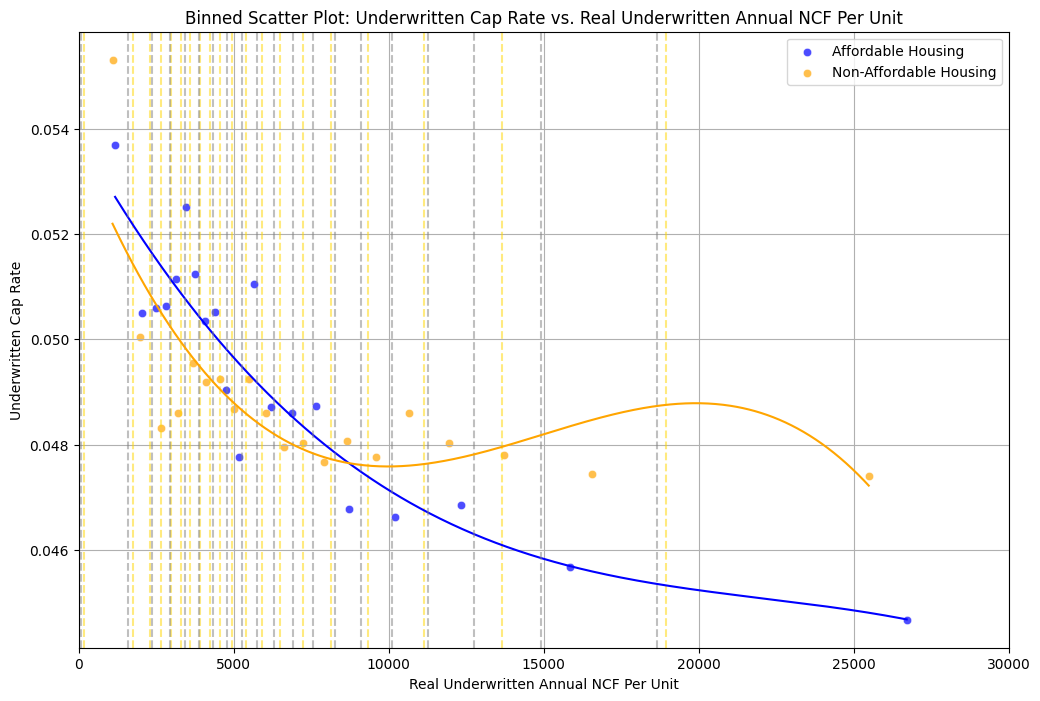

In [4]:
def plot_binned_scatter_cap_rate(data, num_bins=20):
    colors = {1: 'blue', 0: 'orange'}
    labels = {1: 'Affordable Housing', 0: 'Non-Affordable Housing'}
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Loop through Affordable and Non-Affordable housing types
    for affordable in [1, 0]:
        subset = data[data['Affordable Housing Indicator'] == affordable]
        
        # Create bins for Underwritten Annual NCF Per Unit using qcut for equal-sized bins
        subset['NCF_Bin'], bin_edges = pd.qcut(subset['Real Underwritten Annual NCF Per Unit'], q=num_bins, retbins=True, duplicates='drop')
        
        # Calculate the mean Underwritten Cap Rate and count for each bin
        binned_data = subset.groupby('NCF_Bin').agg({
            'Real Underwritten Annual NCF Per Unit': 'mean',
            'Underwritten Cap Rate': 'mean',
            'Note Quarter': 'count'  # Counting the number of entries per bin
        }).reset_index().rename(columns={
            'Real Underwritten Annual NCF Per Unit': 'mean_ncf', 
            'Underwritten Cap Rate': 'mean_cap_rate', 
            'Note Quarter': 'bin_count'
        })
        
        # Plot vertical lines indicating bins
        if affordable == 0:
            for edge in bin_edges:
                plt.axvline(edge, color='grey', linestyle='--', alpha=0.5)
        if affordable == 1:
            for edge in bin_edges:
                plt.axvline(edge, color='gold', linestyle='--', alpha=0.5)
                
        # Plot data points on the secondary y-axis
        sns.scatterplot(
            data=binned_data,
            x='mean_ncf',
            y='mean_cap_rate',
            ax=ax1,
            alpha=0.7,
            label=f'{labels[affordable]}',
            color=colors[affordable]
        )

        # Fit a spline through the binned data points if there are enough points
        if len(binned_data) > 3:  # Ensure there are more than 3 points to fit a spline
            spline = UnivariateSpline(binned_data['mean_ncf'], binned_data['mean_cap_rate'], s=1)
            x_spline = np.linspace(min(binned_data['mean_ncf']), max(binned_data['mean_ncf']), 500)
            y_spline = spline(x_spline)
            ax1.plot(x_spline, y_spline, color=colors[affordable])
    
    # Add labels and title
    ax1.set_xlim(0, 30000)
    ax1.set_xlabel('Real Underwritten Annual NCF Per Unit')
    ax1.set_ylabel('Underwritten Cap Rate', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    plt.title('Binned Scatter Plot: Underwritten Cap Rate vs. Real Underwritten Annual NCF Per Unit')
    plt.legend()
    plt.grid(True)
    plt.show()

# Filter the data
filtered_data = mortgage_activity[
    (mortgage_activity['Underwritten Annual NCF Per Unit'] < 48000) &
    (mortgage_activity['Underwritten Cap Rate'] < 0.25)
]

# Plot the binned scatter plot for both housing types
plot_binned_scatter_cap_rate(filtered_data)

# NOTE: Inforce Figure 6: Relationship Between Net Rent and Net Rental Yield: Affordable Housing    cap_noi_afnaf.png (Fig 7)

## Crediq Data

In [5]:
crediq = pd.read_pickle('crediq_multifamily_data.pickle')
crediq['servicer_loan_id'] = pd.to_numeric(crediq['servicer_loan_id'],errors='coerce')
crediq['dvtransactionid_first5'] = crediq['dvtransactionid'].str[:5]
crediq.loc[crediq['deal_type'] == 'agency', 'deal_type'] = 'freddie_mac'
crediq['prop_size'] = pd.to_numeric(crediq['prop_size'],errors='coerce')
crediq['uw_noi'] = pd.to_numeric(crediq['uw_noi'],errors='coerce')
crediq['appraisal_per_size'] = pd.to_numeric(crediq['appraisal_per_size'],errors='coerce')
crediq['cap_rate'] = pd.to_numeric(crediq['cap_rate'],errors='coerce')
crediq['uw_noi_per_size']=crediq['uw_noi']/crediq['prop_size']

crediq['uw_cap_rate'] = crediq['uw_noi_per_size']/crediq['appraisal_per_size']

GDPDF = pd.read_csv('GDPDEF.csv')

# Step 1: Generate origination_quarter from origination_date in crediq
crediq['origination_date'] = pd.to_datetime(crediq['origination_date'], errors='coerce')
crediq['origination_quarter'] = crediq['origination_date'].dt.to_period('Q')

# Step 2: Merge GDPDF into crediq by origination_quarter
GDPDF['DATE'] = pd.to_datetime(GDPDF['DATE'])
GDPDF['origination_quarter'] = GDPDF['DATE'].dt.to_period('Q')
crediq = crediq.merge(GDPDF[['origination_quarter', 'GDPDEF']], on='origination_quarter', how='left')

# Step 3: Convert uw_noi_per_size into real_uw_noi_per_size using GDP deflator
base_year_gdp_deflator = GDPDF[GDPDF['DATE'] == '2023-01-01']['GDPDEF'].values[0] 
crediq['real_uw_noi_per_size'] = crediq['uw_noi_per_size'] * (base_year_gdp_deflator / crediq['GDPDEF'])
crediq['realappraisal_per_size'] = crediq['appraisal_per_size'] * (base_year_gdp_deflator / crediq['GDPDEF'])

In [6]:
crediq

,_id,loan_id,loan_name,dvtransactionid,cur_bal,maturity_date,status_text,status_code,status_calc,is_defeased,is_distressed,is_watchlisted,is_specialservicing,is_modified,is_paid_off,is_credwatch,is_reo,id,prop_name,crediqid,prop_type,prop_sub_type,lat,lng,address,city,state,zip,msa,county,submarket,prop_size,units,collateral_status,tenants,orig_bal,origination_date,year_built,year_renovated,cap_rate,pct_of_pool,sponsor,borrower,originator,loan_purpose,loan_term,loan_interest_rate,loan_am_type,loan_ltv,loan_subordinate_debt,loan_mezz_debt,uw_noi,uw_ncfdscr,uw_debtyieldncf,appraisal_date,appraisal,appraisal_per_size,ara,most_recent_dscr_ncf,most_recent_occupancy,most_recent_financials_end_date,second_most_recent_dscr_ncf,second_most_recent_occupancy,second_most_recent_financial_end_date,third_most_recent_dscr_ncf,third_most_recent_occupancy,third_most_recent_financial_end_date,owner,master_servicer,special_servicer,servicer_loan_id,deal_type,dvtransactionid_first5,uw_noi_per_size,uw_cap_rate,origination_quarter,GDPDEF,real_uw_noi_per_size,realappraisal_per_size
0,"""bacm2008157001978380534""",7353952,Prairie Grove Apartments,BACM 2008-1,0.00,2018-01-01,Payoff Prior To Maturity (11/01/2017),Payoff Prior To Maturity,Paid Off,False,False,False,False,False,True,False,False,8036933,Prairie Grove Apartments,bacm2008157001978380534,Multifamily,Multifamily,43.089531,-89.215039,700-750 Sandpiper Trial,Cottage Grove,WI,53527,"Madison, WI MSA",Dane County,NaN,65.0000,units,Same as at Contribution,[],4835288.61,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,LaSalle,NaN,NaN,0.06180000000000001,NaN,NaN,NaN,NaN,446323.0000,1.16,NaN,NaN,0.00,NaN,0.000000000000000,1.420,0.94000,2017-06-30,1.300,0.98000,2016-12-31,1.310,1.00000,2015-12-31,NaN,Brean Real Estate Solutions,Brean Real Estate Solutions,10073345.0000,conduit,BACM,6866.5077,NaN,2008Q1,87.3150,9536.0429,NaN
1,"""bacm2008167001249771694""",7353981,Lake Land College Apartments,BACM 2008-1,0.00,2017-05-01,Full Payoff At Maturity (04/28/2017),Full Payoff At Maturity,Paid Off,False,False,False,False,False,True,True,False,8036856,Lake Land College Apartments,bacm2008167001249771694,Multifamily,Multifamily,39.42112,-88.379431,2001 - 2121 Lake Avenue,Mattoon,IL,61938,Non-Metropolitan Area - IL,Coles County,NaN,240.0000,units,Same as at Contribution,[],3653559.52,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,LaSalle,NaN,NaN,0.05640000000000001,NaN,NaN,NaN,NaN,377982.0000,1.27,NaN,NaN,0.00,NaN,0.000000000000000,1.150,0.00000,2016-12-31,1.070,0.67000,2015-12-31,0.690,0.67000,2014-12-31,NaN,Brean Real Estate Solutions,Brean Real Estate Solutions,10073218.0000,conduit,BACM,1574.9250,NaN,2008Q1,87.3150,2187.2185,NaN
2,"""bacm2008ls1380082138679786""",7581812,10-14 Strafford Ave,BACM 2008-LS1,0.00,2017-04-01,Disposition / Liquidation (03/05/2012),Disposition / Liquidation,Paid Off,False,False,False,False,False,True,False,False,8183405,Gorham,bacm2008ls1380082138679786,Multifamily,Multifamily,43.133531,-70.924489,29 Main St,Durham,NH,03824,"Boston-Cambridge-Quincy, MA-NH MSA",Strafford County,NaN,6411.0000,units,Same as at Contribution,[],869940.00,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06100000000000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-02-22,1350000.00,210.5800,0.000000000000000,0.000,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,"Keycorp Real Estate Capital Markets, Inc.","LNR Securities Holdings, LLC",10079240.0000,conduit,BACM,NaN,NaN,2008Q1,87.3150,NaN,292.4485
3,"""bacm2008ls11560012111439790""",7581508,Magnolia Lane Apts,BACM 2008-LS1,0.00,2017-08-01,Payoff Prior To Maturity (05/30/2017),Payoff Prior To Maturity,Paid Off,False,False,False,False,False,True,False,False,8183469,Magnolia Lane Apts,bacm2008ls11560012111439790,Multifamily,Multifamily,33.7998089,-79.0140968596064,1512 Hicks Cir,Conway,SC,29526,"Myrtle Beach-Conway-North Myrtle Beach, SC MSA",Horry County,NaN,48.0000,units,Same as at Contribution,[],3660425.40,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06270000000000001,NaN,NaN,NaN,NaN,351289.0000,1.

In [7]:
mortgage_activity.drop(columns=['ln_median_income', 'median_income'], inplace=True)

In [8]:
crediq = crediq.merge(mortgage_activity,left_on='servicer_loan_id',right_on='Loan Number', how ='left')

In [9]:
crediq.loc[crediq['Loan Acquisition LTV'].notna(), 'loan_ltv'] = crediq['Loan Acquisition LTV']
crediq.loc[crediq['Underwritten DSCR'].notna(), 'uw_ncfdscr'] = crediq['Underwritten DSCR']
#crediq['cap_rate'].fillna(crediq['uw_cap_rate'],inplace=True)
#crediq.loc[crediq['Underwritten Cap Rate'].notna(), 'cap_rate'] = crediq['Underwritten Cap Rate']
crediq['orig_bal'] = pd.to_numeric(crediq['orig_bal'],errors='coerce')
crediq['appraisal'] = pd.to_numeric(crediq['appraisal'],errors='coerce')

crediq['computed_ltv'] = crediq['orig_bal']/crediq['appraisal']

crediq['loan_ltv'].fillna(crediq['computed_ltv'], inplace=True)

crediq['uw_ncfdscr'].fillna(crediq['most_recent_dscr_ncf'],inplace=True)

crediq['uw_ncfdscr'].fillna(crediq['second_most_recent_dscr_ncf'],inplace=True)

crediq['uw_ncfdscr'].fillna(crediq['third_most_recent_dscr_ncf'],inplace=True)

crediq['cap_rate'].fillna(crediq['uw_cap_rate'],inplace=True)
crediq['cap_rate'].fillna(crediq['Underwritten Cap Rate'],inplace=True)

In [10]:
# Filter out rows that are Fannie Mae but do not have a Loan Number matched with the Offical Fannie Mae Data
crediq = crediq[~((crediq['deal_type'] == 'fannie_mae') & (crediq['Loan Number'].isna()))]

In [11]:
crediq.reset_index(drop=True, inplace=True)

In [12]:
crediq = crediq[crediq['deal_type'].isin(['conduit','cre_clo','fannie_mae','freddie_mac','ginnie_mae'])]

In [13]:
crediq['year_built'] = pd.to_numeric(crediq['year_built'],errors='coerce')
crediq['year_built'].fillna(crediq['Year Built'],inplace=True)

In [14]:
crediq = crediq.dropna(subset=['origination_date'])

# Extract the year from origination_date
crediq['origination_year'] = crediq['origination_date'].dt.year.astype(int)
crediq['building_age'] = crediq['origination_year'] - crediq['year_built']

In [15]:
array1 = crediq['state'].unique()

array2 = crediq['Property State'].unique()

in_array1_not_in_array2 = set(array1) - set(array2)
print(in_array1_not_in_array2)

crediq['state'].fillna(crediq['Property State'],inplace=True)

crediq = crediq[~crediq['state'].isin(in_array1_not_in_array2)]

{nan, 'CN', 'NS', 'AB', 'GU', 'QC', 'BC', 'ON', 'NB', 'SK', 'VI'}


In [16]:
crediq['loan_ltv'] = pd.to_numeric(crediq['loan_ltv'], errors='coerce')
crediq['uw_ncfdscr'] = pd.to_numeric(crediq['uw_ncfdscr'], errors='coerce')
crediq['real_uw_noi_per_size'] = pd.to_numeric(crediq['real_uw_noi_per_size'], errors='coerce')
crediq['cap_rate'] = pd.to_numeric(crediq['cap_rate'], errors='coerce')

# Initial full sample size
full_sample_size = crediq.shape[0]

# After eliminating Ginnie Mae loans
non_ginnie_cred = crediq[crediq['deal_type'] != 'ginnie_mae']
non_ginnie_sample_size = non_ginnie_cred.shape[0]

# After eliminating loans if LTV, NOI, or cap rate is missing
non_missing_cred = non_ginnie_cred.dropna(subset=['loan_ltv', 'real_uw_noi_per_size', 'cap_rate'])
non_missing_sample_size = non_missing_cred.shape[0]

# After eliminating LTVs above 100%
ltv_filtered_cred = non_missing_cred[non_missing_cred['loan_ltv'] <= 1]
ltv_filtered_sample_size = ltv_filtered_cred.shape[0]

# After eliminating real NOI per Unit below $1,200 and above $48,000
noi_filtered_cred = ltv_filtered_cred[(ltv_filtered_cred['real_uw_noi_per_size'] >= 1200) & (ltv_filtered_cred['real_uw_noi_per_size'] <= 48000)]
noi_filtered_sample_size = noi_filtered_cred.shape[0]

# After eliminating cap rates below 1% and above 18%
cap_rate_filtered_cred = noi_filtered_cred[(noi_filtered_cred['cap_rate'] >= 0.01) & (noi_filtered_cred['cap_rate'] <= 0.18)]
cap_rate_filtered_sample_size = cap_rate_filtered_cred.shape[0]

# Calculate the percentage dropped at each step
def calculate_percent_dropped(previous_size, current_size):
    return ((previous_size - current_size) / previous_size) * 100

percent_dropped_non_ginnie = calculate_percent_dropped(full_sample_size, non_ginnie_sample_size)
percent_dropped_missing = calculate_percent_dropped(non_ginnie_sample_size, non_missing_sample_size)
percent_dropped_ltv = calculate_percent_dropped(non_missing_sample_size, ltv_filtered_sample_size)
percent_dropped_noi = calculate_percent_dropped(ltv_filtered_sample_size, noi_filtered_sample_size)
percent_dropped_cap_rate = calculate_percent_dropped(noi_filtered_sample_size, cap_rate_filtered_sample_size)

# Calculate the number of samples dropped at each step
samples_dropped_non_ginnie = full_sample_size - non_ginnie_sample_size
samples_dropped_missing = non_ginnie_sample_size - non_missing_sample_size
samples_dropped_ltv = non_missing_sample_size - ltv_filtered_sample_size
samples_dropped_noi = ltv_filtered_sample_size - noi_filtered_sample_size
samples_dropped_cap_rate = noi_filtered_sample_size - cap_rate_filtered_sample_size

# Create a summary dataframe
summary_data = {
    'Filter': [
        'Full sample of loan observations',
        'Eliminating Ginnie Mae loans',
        'Eliminating loans if LTV, NOI, or cap rate is missing',
        'Eliminating LTVs above 100%',
        'Eliminating real NOI per Unit below $1,200 and above $48,000',
        'Eliminating cap rates below 1% and above 18%'
    ],
    'Sample Size': [
        full_sample_size,
        non_ginnie_sample_size,
        non_missing_sample_size,
        ltv_filtered_sample_size,
        noi_filtered_sample_size,
        cap_rate_filtered_sample_size
    ],
    'Percent Dropped': [
        0,
        percent_dropped_non_ginnie,
        percent_dropped_missing,
        percent_dropped_ltv,
        percent_dropped_noi,
        percent_dropped_cap_rate
    ],
    'Samples Dropped': [
        0,
        samples_dropped_non_ginnie,
        samples_dropped_missing,
        samples_dropped_ltv,
        samples_dropped_noi,
        samples_dropped_cap_rate
    ]
}

summary_df = pd.DataFrame(summary_data)

summary_df

# NOTE: Inforce Table 1: Final Sample Selection

,Filter,Sample Size,Percent Dropped,Samples Dropped
0,Full sample of loan observations,159148,0.0000,0
1,Eliminating Ginnie Mae loans,146069,8.2181,13079
2,"Eliminating loans if LTV, NOI, or cap rate is ...",109842,24.8013,36227
3,Eliminating LTVs above 100%,109550,0.2658,292
4,"Eliminating real NOI per Unit below $1,200 and...",106677,2.6225,2873
5,Eliminating cap rates below 1% and above 18%,105923,0.7068,754


In [17]:
mf_usa = cap_rate_filtered_cred

In [18]:
mf_usa['prop_size'].fillna(mf_usa['Property Acquisition Total Unit Count'],inplace=True)

# Drop the non-matched fannie mae data
#mf_usa.dropna(subset=['_id'],inplace=True)

mf_usa['building_age'].fillna(mf_usa['Building Age'],inplace=True)

mf_usa['year_renovated'] = pd.to_numeric(mf_usa['year_renovated'],errors='coerce') 

mf_usa['building_age_renovated'] = mf_usa['origination_year'] - mf_usa['year_renovated']

# Fill missing values in building_age_renovated with values from building_age
mf_usa['building_age_renovated'].fillna(mf_usa['building_age'], inplace=True)

# Replace negative values in building_age_renovated with building_age
mf_usa.loc[mf_usa['building_age_renovated'] < 0, 'building_age_renovated'] = mf_usa['building_age']

#multi_performance = pd.read_csv('FNMA_MF_Loan_Performance_Data_202312.csv')
#multi_performance[['Loan Number','Property Zip Code','Note Date']].drop_duplicates()

#fannie_zip = pd.read_pickle('fannie_zip.pickle')

#mf_usa = mf_usa.merge(fannie_zip,on='Loan Number',how='left')

mf_usa['zip'].fillna(mf_usa['Property Zip Code'],inplace=True)
mf_usa['origination_date'].fillna(mf_usa['Note Date'],inplace=True)

mf_usa['2023_def'] = 121.261/mf_usa['GDPDEF']

mf_usa['real_appraisal_per_size'] = mf_usa['appraisal_per_size']*mf_usa['2023_def']

census = pd.read_pickle('census.pickle')

# Rename ZIP to zip in the census dataframe
census.rename(columns={'ZIP': 'zip','Year':'origination_year'}, inplace=True)

census = census[['median_income', 'origination_year', 'black_ratio', 'poverty_ratio', 'zip']]

census.dropna(subset=['median_income'], inplace=True)
#mf_usa = mf_usa.dropna(subset=['zip'])
# Ensure ZIP codes are strings for both dataframes
mf_usa['zip'] = mf_usa['zip'].astype(str)
census['zip'] = census['zip'].astype(str)
# Drop rows in mf_usa with missing origination_date
mf_usa = mf_usa.dropna(subset=['origination_date'])
print(mf_usa.shape[0])
# Extract the year from origination_date
mf_usa['origination_year'] = mf_usa['origination_date'].dt.year.astype(int)

# Ensure origination_year column in census is of type integer
census['origination_year'] = census['origination_year'].astype(int)

# Sort dataframes by the necessary columns
mf_usa = mf_usa.sort_values(by=['origination_year', 'zip'])
census = census.sort_values(by=['origination_year', 'zip'])

# Ensure that the key columns are properly sorted
mf_usa = mf_usa.reset_index(drop=True)
census = census.reset_index(drop=True)

# Perform merge_asof
mf_usa_census = pd.merge_asof(
    mf_usa,
    census,
    left_on='origination_year',
    right_on='origination_year',
    by='zip',
    direction='nearest',
    suffixes=('', '_census')
)

# Create the 'if_renovated' column
mf_usa_census['if_renovated'] = np.where(
    (~mf_usa_census['year_built'].isna()) & (~mf_usa_census['year_renovated'].isna()), 1,
    np.where(
        (~mf_usa_census['year_built'].isna()) & (mf_usa_census['year_renovated'].isna()), 0,
        np.nan  # Optionally, you can set this to some other value if neither condition is met
    )
)

# Create the 'ln_median_income' column by taking the natural log of 'median_income'
mf_usa_census['ln_median_income'] = np.log(mf_usa_census['median_income'])

# Create the 'ln_appraisal_per_size' column by taking the natural log of 'appraisal_per_size'
mf_usa_census['ln_appraisal_per_size'] = np.log(mf_usa_census['real_appraisal_per_size'])

# Convert 'most_recent_occupancy' to numeric, coercing errors
mf_usa_census['most_recent_occupancy'] = pd.to_numeric(mf_usa_census['most_recent_occupancy'], errors='coerce')

mf_usa_census['Physical Occupancy %'] = mf_usa_census['Physical Occupancy %']/100
mf_usa_census['most_recent_occupancy'].fillna(mf_usa_census['Physical Occupancy %'],inplace=True)
mf_usa_census['if_renovated'].fillna(0,inplace=True)

mf_usa_census = mf_usa_census[mf_usa_census['deal_type'].isin(['fannie_mae','freddie_mac','conduit','cre_clo'])]

mf_usa_census['ln_real_uw_noi_per_size'] = np.log(mf_usa_census['real_uw_noi_per_size'])

105923


#### Loans that cap rate is missing but loan ltv and noi avaiable does not exist

In [19]:
mf_usa[mf_usa['cap_rate'].isna() & mf_usa[['loan_ltv', 'uw_noi_per_size']].notna().all(axis=1)]

,_id,loan_id,loan_name,dvtransactionid,cur_bal,maturity_date,status_text,status_code,status_calc,is_defeased,is_distressed,is_watchlisted,is_specialservicing,is_modified,is_paid_off,is_credwatch,is_reo,id,prop_name,crediqid,prop_type,prop_sub_type,lat,lng,address,city,state,zip,msa,county,submarket,prop_size,units,collateral_status,tenants,orig_bal,origination_date,year_built,year_renovated,cap_rate,pct_of_pool,sponsor,borrower,originator,loan_purpose,loan_term,loan_interest_rate,loan_am_type,loan_ltv,loan_subordinate_debt,loan_mezz_debt,uw_noi,uw_ncfdscr,uw_debtyieldncf,appraisal_date,appraisal,appraisal_per_size,ara,most_recent_dscr_ncf,most_recent_occupancy,most_recent_financials_end_date,second_most_recent_dscr_ncf,second_most_recent_occupancy,second_most_recent_financial_end_date,third_most_recent_dscr_ncf,third_most_recent_occupancy,third_most_recent_financial_end_date,owner,master_servicer,special_servicer,servicer_loan_id,deal_type,dvtransactionid_first5,uw_noi_per_size,uw_cap_rate,origination_quarter,GDPDEF,real_uw_noi_per_size,realappraisal_per_size,Loan Number,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator,Note Quarter,Note Year,Original Term Year,Amortization Year,Building Age,Underwritten Home Value,Underwritten Home Value Per Unit,log_Num_Unit,monthly_rate,Interest Payment,Real Underwritten Home Value Per Unit,Log Real Underwritten Home Value Per Unit,Computed PMT,Computed Paid_Principal,Computed UPB current,Actual Paid_Principal,Actual PMT,Actual Amortization term,Underwritten Annual Debt Service,Underwritten Annual NCF,Underwritten Annual NCF Per Unit,Real Underwritten Annual NCF Per Unit,Log Real Underwritten Annual NCF Per Unit,Underwritten Cap Rate,Affordable Housing Indicator,computed_ltv,origination_year,building_age,building_age_renovated,2023_def,real_appraisal_per_size


In [20]:
print(f'Number of Unique Address-City-State-Zip Code Pairs: {len(mf_usa.drop_duplicates(subset=["address", "city", "state", "zip"]))}')

Number of Unique Address-City-State-Zip Code Pairs: 80608


In [21]:
unique_properties = mf_usa.drop_duplicates(subset=['address', 'city', 'state', 'zip'])
total_units = unique_properties['prop_size'].sum()
print(f'Number of Total Units of each Unique Properties: {total_units}')
#mf_usa.drop_duplicates(subset=['address', 'city', 'state', 'zip'])['prop_size'].sum()

Number of Total Units of each Unique Properties: 11759738.0


In [22]:
mf_usa_census['deal_type'].value_counts()

deal_type
fannie_mae     43765
freddie_mac    39771
conduit        20181
cre_clo         2206
Name: count, dtype: int64

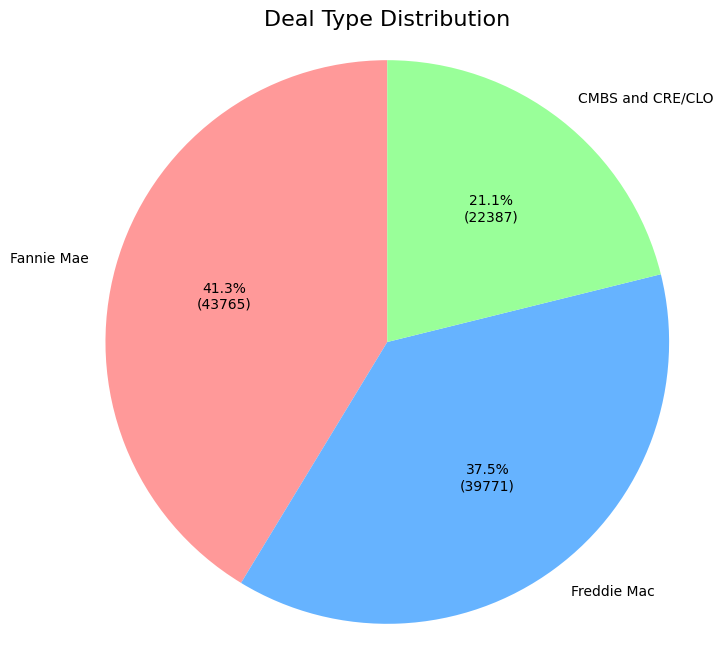

In [23]:
# Create a new column 'deal_type_cleaned' by replacing specific values in 'deal_type'
mf_usa_census['deal_type_cleaned'] = mf_usa_census['deal_type'].replace({
    'fannie_mae': 'Fannie Mae',
    'freddie_mac': 'Freddie Mac',
    'cre_clo': 'CMBS and CRE/CLO',
    'conduit': 'CMBS and CRE/CLO'
})

# Define a function to show both percentage and count in the pie chart
def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return f'{pct:.1f}%\n({absolute:d})'

# Get the value counts for 'deal_type_cleaned'
deal_type_cleaned_counts = mf_usa_census['deal_type_cleaned'].value_counts()

# Define a custom color palette
custom_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']  # Replace with any colors you like

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(deal_type_cleaned_counts, 
        labels=deal_type_cleaned_counts.index, 
        autopct=lambda pct: func(pct, deal_type_cleaned_counts),  # Custom labels with percentage and counts
        startangle=90, 
        colors=custom_colors)  # Apply the custom color palette

# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Deal Type Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio to ensure the pie chart is circular
plt.show()

# NOTE: Inforce Figure 1: The Deal Type Distribution   pie_deal.png

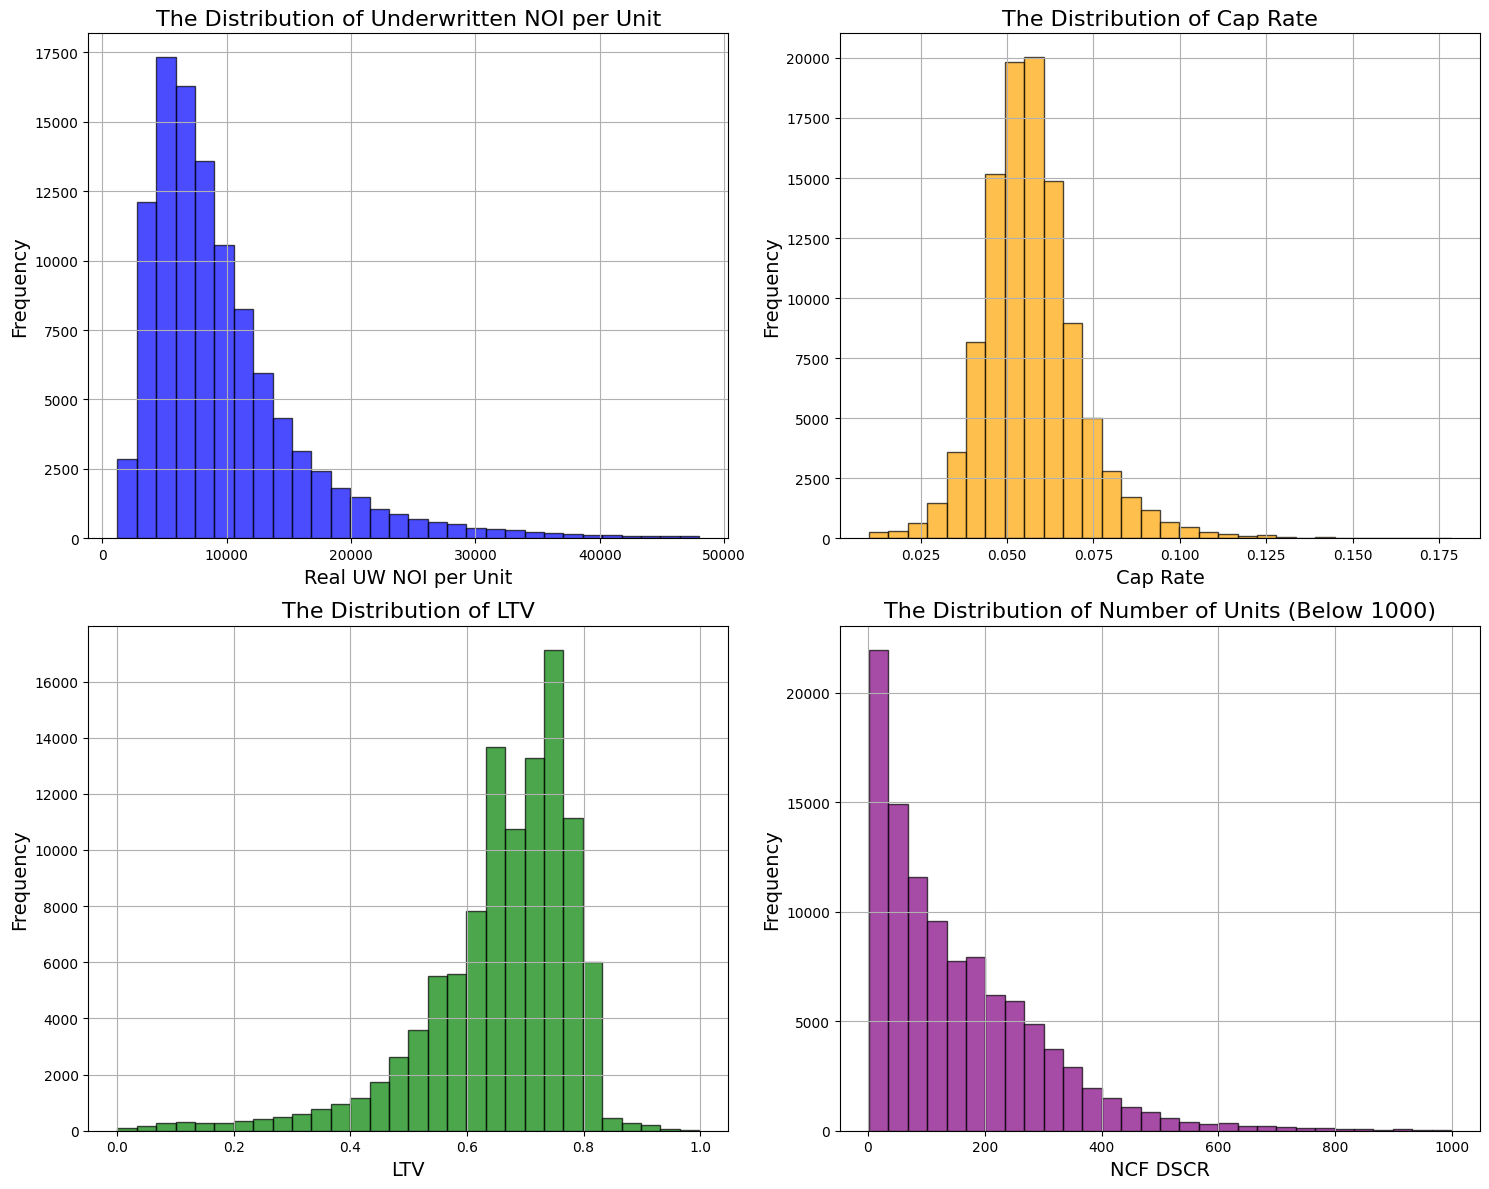

In [24]:
# Define a function to plot histograms
def plot_histogram(data, column, color, title, xlabel, bins=30):
    plt.hist(data[column].dropna(), bins=bins, color=color, edgecolor='black', alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)

# Set up the figure with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot each histogram in a separate subplot
plt.sca(axs[0, 0])
plot_histogram(mf_usa, 'real_uw_noi_per_size', 'blue', 'The Distribution of Underwritten NOI per Unit', 'Real UW NOI per Unit', bins=30)

plt.sca(axs[0, 1])
plot_histogram(mf_usa, 'cap_rate', 'orange', 'The Distribution of Cap Rate', 'Cap Rate', bins=30)

plt.sca(axs[1, 0])
plot_histogram(mf_usa, 'loan_ltv', 'green', 'The Distribution of LTV', 'LTV', bins=30)

plt.sca(axs[1, 1])
plot_histogram(mf_usa[mf_usa['prop_size'] < 1000], 'prop_size', 'purple', 'The Distribution of Number of Units (Below 1000)', 'NCF DSCR', bins=30)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# NOTE: Inforce Figure 2: Distribution of Key Variables in Final Sample   Dist_noi_cap_ltv_unit.png

Decile Summary:
Bin Range                 Mean Cap Rate   Bin Count 
1202.65 to 3881.46  0.0624          10593     
3881.46 to 4899.55  0.0633          10592     
4899.55 to 5837.84  0.0616          10592     
5837.84 to 6818.74  0.0599          10592     
6818.74 to 7908.48  0.0579          10593     
7908.48 to 9185.47  0.0561          10592     
9185.47 to 10797.66  0.0538          10592     
10797.66 to 13062.70  0.0529          10592     
13062.70 to 17357.35  0.0517          10592     
17357.35 to 47994.44  0.0521          10593     


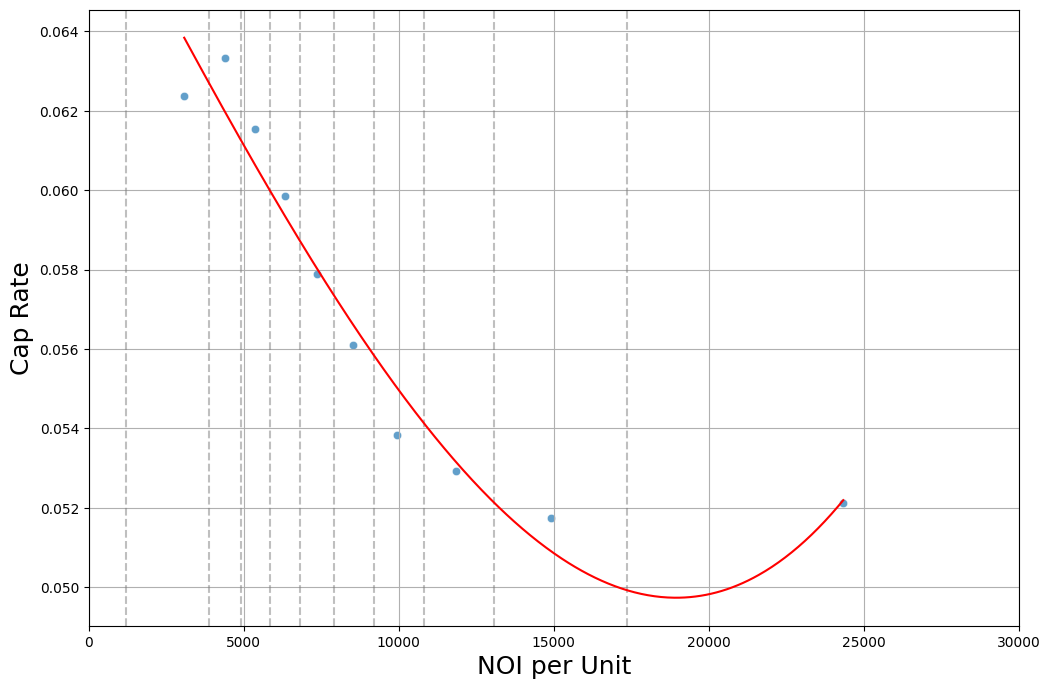

In [25]:
# Filter the data based on the given conditions
filtered_crediq = mf_usa_census.copy()
# Define the number of bins
#num_bins = 10

def plot_binned_scatter(data, num_bins=10):
    # Create bins for real_uw_noi_per_size using qcut for equal-sized bins
    data['NOI_Bin'], bin_edges = pd.qcut(data['real_uw_noi_per_size'], q=num_bins, retbins=True, duplicates='drop')
    
    # Calculate the mean Cap Rate, count, and other stats for each bin
    binned_data = data.groupby('NOI_Bin').agg({
        'real_uw_noi_per_size': 'mean',
        'cap_rate': 'mean',  # Mean Cap Rate
        'deal_type': 'count'  # Count of data points
    }).reset_index().rename(columns={'real_uw_noi_per_size': 'mean_noi', 'cap_rate': 'mean_cap_rate', 'deal_type': 'bin_count'})
    
    # Print bin edges and average cap rate for each decile
    print("Decile Summary:")
    print(f"{'Bin Range':<25} {'Mean Cap Rate':<15} {'Bin Count':<10}")
    for i, edge in enumerate(bin_edges[:-1]):
        print(f"{edge:.2f} to {bin_edges[i+1]:.2f}  {binned_data['mean_cap_rate'].iloc[i]:<15.4f} {binned_data['bin_count'].iloc[i]:<10}")
    
    # Plot setup
    fig, ax2 = plt.subplots(figsize=(12, 8))

    # Plot vertical lines indicating bins
    for edge in bin_edges:
        plt.axvline(edge, color='grey', linestyle='--', alpha=0.5)
        
    # Plot data points on the secondary y-axis
    sns.scatterplot(
        data=binned_data,
        x='mean_noi',
        y='mean_cap_rate',
        ax=ax2,
        alpha=0.7
    )

    # Fit a spline through the binned data points
    if not binned_data.empty:
        spline = UnivariateSpline(binned_data['mean_noi'], binned_data['mean_cap_rate'], s=1)
        x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
        y_spline = spline(x_spline)
        ax2.plot(x_spline, y_spline, label='Spline Smoothing', color='red')

    # Set x-axis limit to 30,000
    ax2.set_xlim(0, 30000)
    
    # Add labels and title
    ax2.set_xlabel('NOI per Unit', fontsize=18)
    ax2.set_ylabel('Cap Rate', color='black', fontsize=18)
    ax2.tick_params(axis='y', labelcolor='black')
    plt.grid(True)
    plt.show()

# Plot the binned scatter plot for all deal types together
plot_binned_scatter(filtered_crediq)

# NOTE: Inforce Figure 3: The Relationship Between Net Rent and Net Rental Yield    CapRatevsNOI.png
# NOTE: Inforce Table 5: Net Rental Yield, Capital Gain, and Total Return by Rental Income Decile

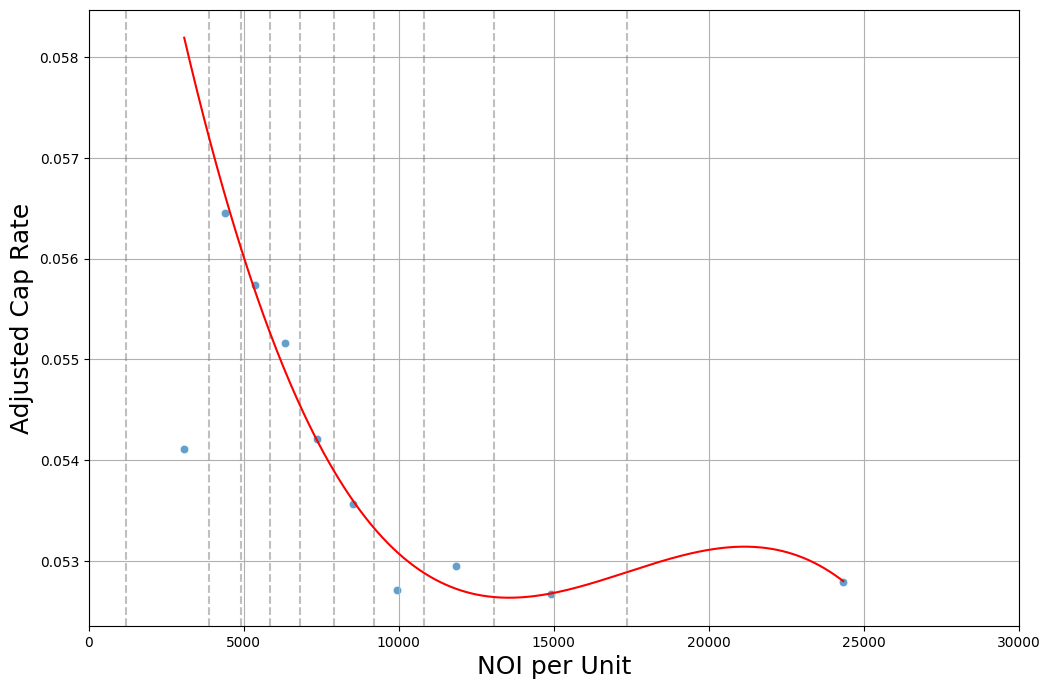

In [26]:
filtered_crediq = mf_usa_census.copy()
#filtered_crediq.dropna(subset=['_id'],inplace=True)
#filtered_crediq = filtered_crediq[filtered_crediq['_id'].isna()]
filtered_crediq = filtered_crediq[['cap_rate', 'real_uw_noi_per_size', 'state', 'origination_year', 'deal_type']]

prepared_X = pd.get_dummies(filtered_crediq, columns=['state', 'origination_year','deal_type'], drop_first=True)
prepared_X = prepared_X.astype({col: int for col in prepared_X.columns if prepared_X[col].dtype == bool})
independent_vars = [col for col in prepared_X.columns if col not in ['cap_rate','real_uw_noi_per_size']]
X = prepared_X[independent_vars]
X = sm.add_constant(X)
y = prepared_X['cap_rate']
model = sm.OLS(y, X).fit()
 # Extract coefficients
intercept = model.params['const']
#beta_noi = model.params['real_uw_noi_per_size']
fe_2019 = model.params['origination_year_2019']
state_coeffs = {col: model.params[col] for col in model.params.index if 'state_' in col}

# Calculate the proportion of each state in the subset
state_proportions = prepared_X[[col for col in prepared_X.columns if 'state_' in col]].mean()

# Calculate the weighted average state fixed effect
weighted_avg_state_fe = sum(state_coeffs[col] * state_proportions[col] for col in state_proportions.index)

deal_coeffs = {col: model.params[col] for col in model.params.index if 'deal_type_' in col}
deal_proportions = prepared_X[[col for col in prepared_X.columns if 'deal_type_' in col]].mean()
weighted_avg_deal_fe = sum(deal_coeffs[col] * deal_proportions[col] for col in deal_proportions.index)

# Compute the adjusted cap rate
prepared_X['adjusted_cap_rate'] = intercept + fe_2019 + weighted_avg_state_fe + weighted_avg_deal_fe+ model.resid
filtered_crediq['adjusted_cap_rate'] = prepared_X['adjusted_cap_rate']
# Define the number of bins
num_bins = 20

# Function to plot the binned scatter plot without histogram for all deal types together
def plot_binned_scatter(data, num_bins=10):
    # Create bins for real_uw_noi_per_size using qcut for equal-sized bins
    data['NOI_Bin'], bin_edges = pd.qcut(data['real_uw_noi_per_size'], q=num_bins, retbins=True, duplicates='drop')
    
    # Calculate the mean Cap Rate and count for each bin
    binned_data = data.groupby('NOI_Bin').agg({
        'real_uw_noi_per_size': 'mean',
        'adjusted_cap_rate': 'mean',
        'deal_type': 'count'
    }).reset_index().rename(columns={'real_uw_noi_per_size': 'mean_noi', 'adjusted_cap_rate': 'mean_cap_rate', 'deal_type': 'bin_count'})
    
    fig, ax2 = plt.subplots(figsize=(12, 8))

    # Create bins for the x variable using qcut for equal-sized bins
    data['bin'], bin_edges = pd.qcut(data['real_uw_noi_per_size'], q=num_bins, retbins=True, duplicates='drop')
    
    # Plot vertical lines indicating bins
    for edge in bin_edges:
        plt.axvline(edge, color='grey', linestyle='--', alpha=0.5)
        
    # Plot data points on the secondary y-axis
    sns.scatterplot(
        data=binned_data,
        x='mean_noi',
        y='mean_cap_rate',
        ax=ax2,
        alpha=0.7
    )

    # Fit a spline through the binned data points
    spline = UnivariateSpline(binned_data['mean_noi'][1:], binned_data['mean_cap_rate'][1:], s=1)
    x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
    y_spline = spline(x_spline)
    ax2.plot(x_spline, y_spline, label='Spline Smoothing', color='red')

    # Set x-axis limit to 30,000
    ax2.set_xlim(0, 30000)
    
    # Add labels and title
    ax2.set_xlabel('NOI per Unit', fontsize=18)
    ax2.set_ylabel('Adjusted Cap Rate', color='black', fontsize=18)
    ax2.tick_params(axis='y', labelcolor='black')
    #plt.title('Binned Scatter Plot: Adjusted Cap Rate vs. Real UW NOI per Unit', fontsize=20)
    plt.grid(True)
    plt.show()

# Plot the binned scatter plot for all deal types together
plot_binned_scatter(filtered_crediq)

# NOTE: Inforce Figure 4: Adjusted Relationship Between Net Rent and Net Rental Yield   CP_contr_method1.png

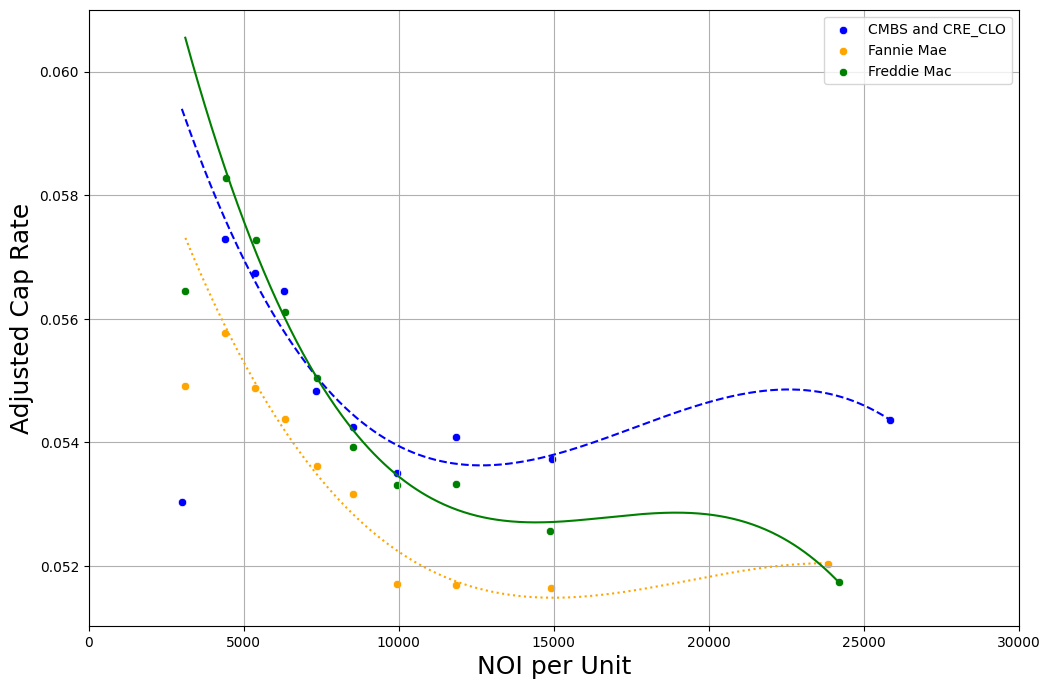

In [27]:
filtered_crediq = mf_usa_census.copy()
#filtered_crediq.dropna(subset=['_id'],inplace=True)
filtered_crediq = filtered_crediq[['cap_rate', 'real_uw_noi_per_size', 'state', 'origination_year', 'deal_type']]
# Store deal_type before creating dummies
filtered_crediq['original_deal_type'] = filtered_crediq['deal_type']
filtered_crediq['NOI_Bin'], bin_edges = pd.qcut(filtered_crediq['real_uw_noi_per_size'], q=10, retbins=True, duplicates='drop')

# Rename the bins to numbers from 1 to 20
bin_labels = list(range(1, len(filtered_crediq['NOI_Bin'].cat.categories) + 1))
filtered_crediq['NOI_Bin'] = filtered_crediq['NOI_Bin'].cat.rename_categories(bin_labels)
filtered_crediq['original_NOI_Bin'] = filtered_crediq['NOI_Bin']
# Define dummy variables for state, origination_year, deal_type, and NOI_Bin
filtered_crediq = pd.get_dummies(filtered_crediq, columns=['state', 'origination_year', 'deal_type', 'NOI_Bin'], drop_first=True)

filtered_crediq = filtered_crediq.astype({col: int for col in filtered_crediq.columns if filtered_crediq[col].dtype == bool})
# Generate interaction terms for deal_type and NOI_Bin
for originator in ['freddie_mac', 'fannie_mae', 'cre_clo']:
    for binn in range(2,11):
        filtered_crediq[f'{originator}_NOI_Bin_{binn}'] = filtered_crediq[f'deal_type_{originator}'] * filtered_crediq[f'NOI_Bin_{binn}']

# Define the independent variables (excluding the dependent variable 'cap_rate')
independent_vars = [col for col in filtered_crediq.columns if col not in ['cap_rate', 'real_uw_noi_per_size','original_deal_type','original_NOI_Bin']]
independent_vars = [col for col in independent_vars if not (col.startswith('deal_type_') or col.startswith('NOI_Bin_'))]

# Run the regression
X = filtered_crediq[independent_vars]
X = sm.add_constant(X)
y = filtered_crediq['cap_rate']
model = sm.OLS(y, X).fit()
# Extract coefficients
intercept = model.params['const']

#noi_bin_coeffs = {col: model.params[col] for col in model.params.index if 'NOI_Bin_' in col}
interaction_coeffs = {col: model.params[col] for col in model.params.index if '_' in col and 'NOI_Bin_' in col}

interaction_terms_matrix = filtered_crediq[list(interaction_coeffs.keys())].dot(pd.Series(interaction_coeffs))


#beta_noi = model.params['real_uw_noi_per_size']
fe_2019 = model.params['origination_year_2019']
state_coeffs = {col: model.params[col] for col in model.params.index if 'state_' in col}

# Calculate the proportion of each state in the subset
state_proportions = X[[col for col in X.columns if 'state_' in col]].mean()

# Calculate the weighted average state fixed effect
weighted_avg_state_fe = sum(state_coeffs[col] * state_proportions[col] for col in state_proportions.index)


filtered_crediq['adjusted_cap_rate'] = intercept + interaction_terms_matrix + fe_2019 + weighted_avg_state_fe + model.resid


filtered_crediq.loc[filtered_crediq['original_deal_type'] == 'conduit', 'original_deal_type'] = 'CMBS and CRE_CLO'
filtered_crediq.loc[filtered_crediq['original_deal_type'] == 'cre_clo', 'original_deal_type'] = 'CMBS and CRE_CLO'

# Prepare the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Update the colors dictionary with new legend labels
colors = {
    'Fannie Mae': 'orange',
    'CMBS and CRE_CLO': 'blue',
    'Freddie Mac': 'green'
}

# Update the linestyles dictionary with new legend labels
linestyles = {
    'Fannie Mae': 'dotted',
    'CMBS and CRE_CLO': 'dashed',
    'Freddie Mac': 'solid'
}

# Update originator groups with new legend labels
originator_groups = ['CMBS and CRE_CLO', 'Fannie Mae', 'Freddie Mac']

# Replace values in the dataframe to match the new labels
filtered_crediq['original_deal_type'].replace({'fannie_mae': 'Fannie Mae', 'freddie_mac': 'Freddie Mac'}, inplace=True)

# Compute adjusted cap rates for each originator type within the same calculation
for originator in originator_groups:
    subset = filtered_crediq[filtered_crediq['original_deal_type'] == originator]

    # Calculate the mean Cap Rate and count for each bin
    binned_data = subset.groupby('original_NOI_Bin').agg({
        'real_uw_noi_per_size': 'mean',
        'adjusted_cap_rate': 'mean'
    }).reset_index().rename(columns={'real_uw_noi_per_size': 'mean_noi', 'adjusted_cap_rate': 'mean_adjusted_cap_rate'})

    # Plot data points on the primary axis
    sns.scatterplot(
        data=binned_data,
        x='mean_noi',
        y='mean_adjusted_cap_rate',
        label=originator,
        color=colors[originator],
        ax=ax
    )

    # Fit a spline through the binned data points
    spline = UnivariateSpline(binned_data['mean_noi'][1:], binned_data['mean_adjusted_cap_rate'][1:], s=1)
    x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
    y_spline = spline(x_spline)

    # Plot the spline smoothed line with different line styles
    ax.plot(x_spline, y_spline, color=colors[originator], linestyle=linestyles[originator])

# Set x-axis limit to 30,000
    ax.set_xlim(0, 30000)

# Add labels and title
ax.set_xlabel('NOI per Unit', fontsize=18)
ax.set_ylabel('Adjusted Cap Rate', fontsize=18)
#plt.title('Binned Scatter Plot: Adjusted Cap Rate vs. Real UW NOI per Unit for Different Deal Types', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

# NOTE: Inforce Figure 5: Adjusted Relationship Between Net Rent and Net Rental Yield Across Deal Types     CP_contr_method2.png

## By Loan Purpose

In [28]:
# Combine 'Acquisition' and 'Purchase' into 'Acquisition and Purchase'
mf_usa_census['new_loan_purpose'] = mf_usa_census['loan_purpose'].replace({'Acquisition': 'Acquisition and Purchase', 'Purchase': 'Acquisition and Purchase'})

In [29]:
mf_usa_census['new_loan_purpose'].value_counts()

new_loan_purpose
Refinance                                                                                                                                         51995
Acquisition and Purchase                                                                                                                          28489
Supplemental                                                                                                                                       3495
Recapitalization                                                                                                                                     98
Forward Conversion                                                                                                                                   96
Equity                                                                                                                                               63
New Construction                                                       

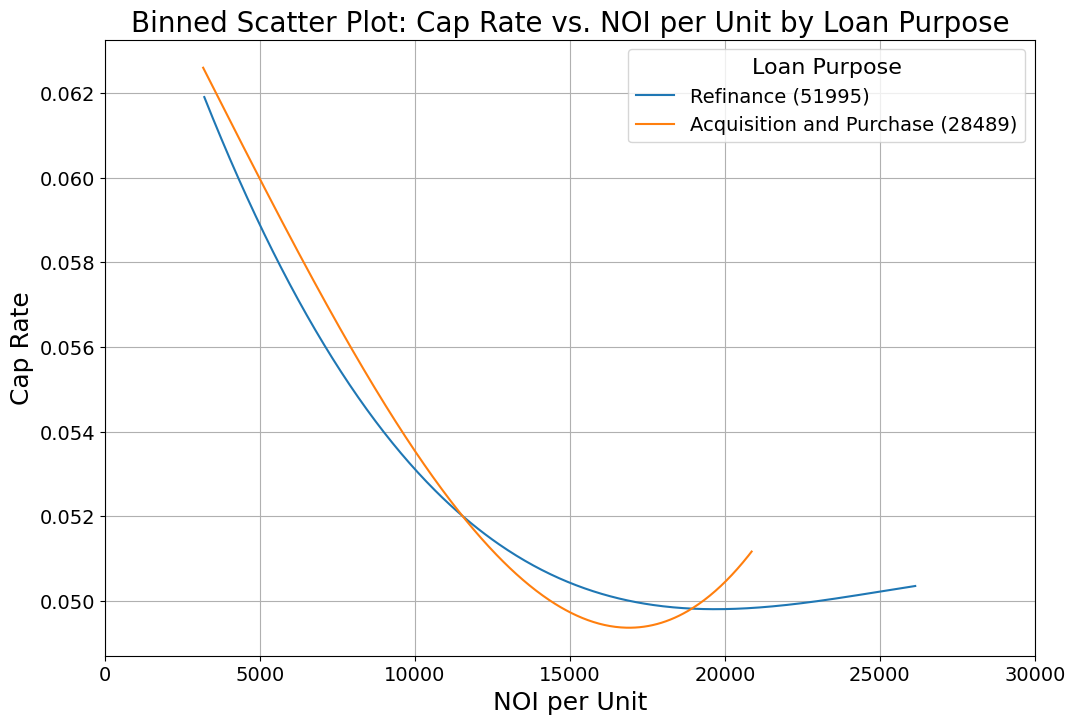

In [30]:
# Filter the data based on the specified loan purposes
filtered_crediq = mf_usa_census[mf_usa_census['new_loan_purpose'].isin(['Refinance', 'Acquisition and Purchase'])].copy()

# Function to plot the binned scatter plot by new_loan_purpose
def plot_binned_scatter_by_purpose(data, num_bins=10):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Iterate through each new_loan_purpose
    for purpose in data['new_loan_purpose'].unique():
        # Filter data for the specific purpose
        subset = data[data['new_loan_purpose'] == purpose]
        
        # Create bins for real_uw_noi_per_size using qcut for equal-sized bins
        subset['NOI_Bin'], bin_edges = pd.qcut(subset['real_uw_noi_per_size'], q=num_bins, retbins=True, duplicates='drop')
        
        # Calculate the mean Cap Rate and mean NOI for each bin
        binned_data = subset.groupby('NOI_Bin').agg({
            'real_uw_noi_per_size': 'mean',
            'cap_rate': 'mean'
        }).reset_index().rename(columns={'real_uw_noi_per_size': 'mean_noi', 'cap_rate': 'mean_cap_rate'})
        
        # Fit a spline through the binned data points
        spline = UnivariateSpline(binned_data['mean_noi'], binned_data['mean_cap_rate'], s=1)
        x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
        y_spline = spline(x_spline)
        
        # Plot the spline line
        ax.plot(x_spline, y_spline, label=f'{purpose} ({len(subset)})')

    # Set x-axis limit to 30,000
    ax.set_xlim(0, 30000)
    
    # Add labels, title, and legend
    ax.set_xlabel('NOI per Unit', fontsize=18)
    ax.set_ylabel('Cap Rate', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(title='Loan Purpose', fontsize=14, title_fontsize=16)
    plt.title('Binned Scatter Plot: Cap Rate vs. NOI per Unit by Loan Purpose', fontsize=20)
    plt.grid(True)
    plt.show()

# Plot the binned scatter plot by new_loan_purpose
plot_binned_scatter_by_purpose(filtered_crediq)


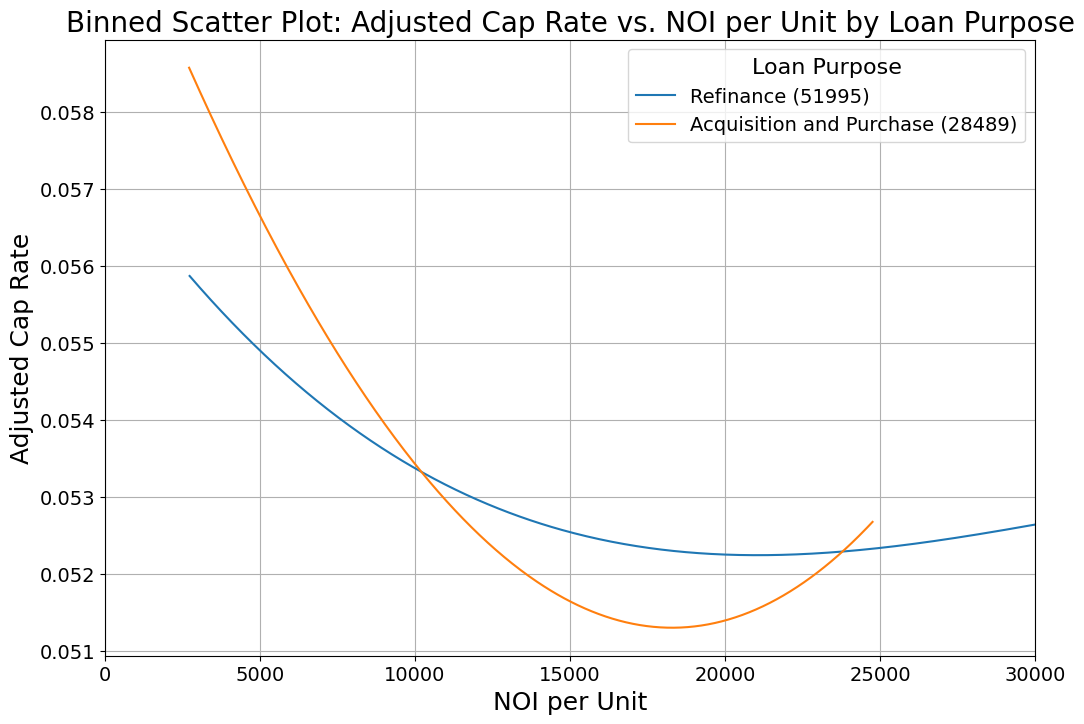

In [31]:
# Prepare the data
filtered_crediq = mf_usa_census[['cap_rate', 'real_uw_noi_per_size', 'state', 'origination_year', 'deal_type', 'new_loan_purpose']].copy()
# Filter the data based on the specified loan purposes
#filtered_crediq = filtered_crediq[filtered_crediq['new_loan_purpose'].isin(['Refinance', 'Acquisition and Purchase'])].copy()
prepared_X = pd.get_dummies(filtered_crediq, columns=['state', 'origination_year', 'deal_type'], drop_first=True)
prepared_X = prepared_X.astype({col: int for col in prepared_X.columns if prepared_X[col].dtype == bool})
independent_vars = [col for col in prepared_X.columns if col not in ['cap_rate', 'real_uw_noi_per_size','new_loan_purpose']]
X = prepared_X[independent_vars]
X = sm.add_constant(X)
y = prepared_X['cap_rate']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Extract coefficients
intercept = model.params['const']
fe_2019 = model.params.get('origination_year_2019', 0)
state_coeffs = {col: model.params[col] for col in model.params.index if 'state_' in col}
state_proportions = prepared_X[[col for col in prepared_X.columns if 'state_' in col]].mean()
weighted_avg_state_fe = sum(state_coeffs[col] * state_proportions[col] for col in state_proportions.index)

deal_coeffs = {col: model.params[col] for col in model.params.index if 'deal_type_' in col}
deal_proportions = prepared_X[[col for col in prepared_X.columns if 'deal_type_' in col]].mean()
weighted_avg_deal_fe = sum(deal_coeffs[col] * deal_proportions[col] for col in deal_proportions.index)

# Compute the adjusted cap rate
prepared_X['adjusted_cap_rate'] = intercept + fe_2019 + weighted_avg_state_fe + weighted_avg_deal_fe + model.resid
filtered_crediq['adjusted_cap_rate'] = prepared_X['adjusted_cap_rate']
filtered_crediq = filtered_crediq[filtered_crediq['new_loan_purpose'].isin(['Refinance', 'Acquisition and Purchase'])].copy()

# Function to plot binned scatter plots by `new_loan_purpose`
def plot_binned_scatter_by_purpose(data, num_bins=20):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Iterate through each `new_loan_purpose`
    for purpose in data['new_loan_purpose'].unique():
        # Filter data for the specific purpose
        subset = data[data['new_loan_purpose'] == purpose]
        
        # Create bins for `real_uw_noi_per_size` using qcut
        subset['NOI_Bin'], bin_edges = pd.qcut(subset['real_uw_noi_per_size'], q=num_bins, retbins=True, duplicates='drop')
        
        # Calculate mean cap rate and mean NOI for each bin
        binned_data = subset.groupby('NOI_Bin').agg({
            'real_uw_noi_per_size': 'mean',
            'adjusted_cap_rate': 'mean'
        }).reset_index().rename(columns={
            'real_uw_noi_per_size': 'mean_noi',
            'adjusted_cap_rate': 'mean_cap_rate'
        })
        
        # Fit a spline through the binned data points
        spline = UnivariateSpline(binned_data['mean_noi'], binned_data['mean_cap_rate'], s=1)
        x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
        y_spline = spline(x_spline)
        
        # Plot the spline line
        ax.plot(x_spline, y_spline, label=f'{purpose} ({len(subset)})')

    # Set x-axis limit
    ax.set_xlim(0, 30000)
    
    # Add labels, title, and legend
    ax.set_xlabel('NOI per Unit', fontsize=18)
    ax.set_ylabel('Adjusted Cap Rate', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(title='Loan Purpose', fontsize=14, title_fontsize=16)
    plt.title('Binned Scatter Plot: Adjusted Cap Rate vs. NOI per Unit by Loan Purpose', fontsize=20)
    plt.grid(True)
    plt.show()

# Plot the binned scatter plot by `new_loan_purpose`
plot_binned_scatter_by_purpose(filtered_crediq)

In [32]:
mf_usa_census = mf_usa_census[mf_usa_census['address']!='Various']

In [33]:
mf_usa_census['ln_real_app_per_size'] = np.log(mf_usa_census['real_appraisal_per_size'])
mf_usa_census['building_age_sq'] = mf_usa_census['building_age']**2
mf_usa_census['ln_prop_size'] = np.log(mf_usa_census['prop_size'])

In [34]:
mf_usa_census.to_pickle('mf_usa_census.pickle')

In [35]:
dependent_var = 'ln_real_app_per_size'
regressors = ['_id','state','ln_median_income','building_age','building_age_sq','if_renovated','ln_real_uw_noi_per_size','ln_prop_size','origination_year' ,'deal_type']
regressors.append(dependent_var)
prepeared_X = mf_usa_census[regressors]
prepeared_X.dropna(inplace=True)
if 'deal_type' in prepeared_X.columns:
    prepeared_X = prepeared_X[prepeared_X['deal_type'].isin(['fannie_mae', 'conduit',
                                                             'freddie_mac', 'cre_clo'])]
    prepeared_X = pd.get_dummies(prepeared_X,columns=['deal_type'])
    prepeared_X.drop(columns=['deal_type_fannie_mae'],inplace=True)
    
prepeared_X = pd.get_dummies(prepeared_X,columns=['state','origination_year'],drop_first=False)
prepeared_X.drop(columns=['origination_year_2000','state_NY'],inplace=True)
prepeared_X = prepeared_X.astype({col: int for col in prepeared_X.columns if prepeared_X[col].dtype == bool})
#prepeared_X = prepeared_X.apply(pd.to_numeric, errors='coerce')
prepeared_X.dropna(inplace=True)
y = prepeared_X[dependent_var]
X = prepeared_X.drop(columns=[dependent_var,'_id'])
X['building_age'] = X['building_age'].astype(float)
X['building_age_sq'] = X['building_age_sq'].astype(float)
X = sm.add_constant(X)

# Create the model
crediq_homevalue_model = sm.OLS(y, X).fit()

prepeared_X['home_resid_with_noi'] = crediq_homevalue_model.resid
mf_usa_census = mf_usa_census.merge(prepeared_X[['_id','home_resid_with_noi']],on='_id',how='left')

## Repeated Sales Analysis

In [36]:

# 1. Select relevant columns including 'city' and 'zip' for duplicate identification  
mf_usa_repeated_app = mf_usa_census[['address', 'city', 'state', 'zip', 'appraisal_date', 'real_appraisal_per_size', 'home_resid_with_noi', 'building_age_sq', '_id']].drop_duplicates()

# 2. Drop rows with missing appraisal_date or real_appraisal_per_size
mf_usa_repeated_app.dropna(subset=['appraisal_date', 'real_appraisal_per_size'], inplace=True)

# 3. Group by the combination of 'address', 'city', 'state', and 'zip' to count occurrences
group_columns = ['address', 'city', 'state', 'zip']
mf_usa_repeated_app_count = mf_usa_repeated_app.groupby(group_columns).size().to_frame('count').reset_index()

# 4. Identify combinations with more than one appraisal
mf_usa_repeated_list = mf_usa_repeated_app_count[mf_usa_repeated_app_count['count'] > 1]

# 5. Merge to filter the original dataframe based on the repeated combinations
mf_usa_repeated = pd.merge(
    mf_usa_census,
    mf_usa_repeated_list[group_columns],
    on=group_columns,
    how='inner'
)

# 6. Drop rows with missing appraisal_date or real_appraisal_per_size
mf_usa_repeated.dropna(subset=['appraisal_date', 'real_appraisal_per_size'], inplace=True)

# 7. Sort by the grouping columns and appraisal_date
mf_usa_repeated.sort_values(by=group_columns + ['appraisal_date'], inplace=True)

# 8. Ensure correct data types
mf_usa_repeated['appraisal_date'] = pd.to_datetime(mf_usa_repeated['appraisal_date'], errors='coerce')
mf_usa_repeated['real_appraisal_per_size'] = pd.to_numeric(mf_usa_repeated['real_appraisal_per_size'], errors='coerce')
mf_usa_repeated.dropna(subset=['appraisal_date', 'real_appraisal_per_size'], inplace=True)

# 9. Initialize lists to store results, including first_id, second_id, home_resid_with_noi, and building_age_sq
first_ids = []
second_ids = []
returns_list = []
addresses_list = []
cities_list = []
states_list = []
zips_list = []
appraisal_dates_first_list = []
appraisal_dates_second_list = []
first_appraisal_values = []
second_appraisal_values = []
first_zip_codes = []
second_zip_codes = []
first_real_uw_noi_per_size = []
second_real_uw_noi_per_size = []
first_ln_real_uw_noi_per_size = []
second_ln_real_uw_noi_per_size = []
first_origination_years = []
second_origination_years = []
first_building_ages = []
second_building_ages = []
first_building_age_sq = []    # For building age squared
second_building_age_sq = []
first_if_renovated = []
second_if_renovated = []
first_home_resid_with_noi = []    # For home residence with NOI
second_home_resid_with_noi = []
first_ln_median_incomes = []
second_ln_median_incomes = []
first_deal_types = []
second_deal_types = []
first_states = []
second_states = []
first_most_recent_occupancy = []
second_most_recent_occupancy = []
first_cap_rate = []
second_cap_rate = []

# 10. Group by the combination of 'address', 'city', 'state', and 'zip'
for _, group in mf_usa_repeated.groupby(group_columns):
    group = group.sort_values(by='appraisal_date').reset_index(drop=True)  # Ensure the group is sorted by appraisal_date
    for i in range(1, len(group)):
        P_t = group.loc[i-1, 'real_appraisal_per_size']
        P_t_plus_T = group.loc[i, 'real_appraisal_per_size']
        T = (group.loc[i, 'appraisal_date'] - group.loc[i-1, 'appraisal_date']).days / 365.25
        
        if T > 0 and P_t > 0 and P_t_plus_T > 0:
            annualized_return = (np.log(P_t_plus_T) - np.log(P_t)) / T
            returns_list.append(annualized_return)
            
            # Append first_id and second_id from '_id'
            first_ids.append(group.loc[i-1, '_id'])
            second_ids.append(group.loc[i, '_id'])
            
            # Append grouping information
            addresses_list.append(group.loc[i, 'address'])
            cities_list.append(group.loc[i, 'city'])
            states_list.append(group.loc[i, 'state'])
            zips_list.append(group.loc[i, 'zip'])
            
            # Append appraisal dates and values
            appraisal_dates_first_list.append(group.loc[i-1, 'appraisal_date'])
            appraisal_dates_second_list.append(group.loc[i, 'appraisal_date'])
            first_appraisal_values.append(P_t)
            second_appraisal_values.append(P_t_plus_T)
            
            # Append zip codes and state (redundant if grouping ensures they are the same)
            first_zip_codes.append(group.loc[i-1, 'zip'])
            second_zip_codes.append(group.loc[i, 'zip'])
            
            # Append additional property details
            first_real_uw_noi_per_size.append(group.loc[i-1, 'real_uw_noi_per_size'])
            second_real_uw_noi_per_size.append(group.loc[i, 'real_uw_noi_per_size'])
            first_ln_real_uw_noi_per_size.append(group.loc[i-1, 'ln_real_uw_noi_per_size'])
            second_ln_real_uw_noi_per_size.append(group.loc[i, 'ln_real_uw_noi_per_size'])
            first_origination_years.append(group.loc[i-1, 'origination_year'])
            second_origination_years.append(group.loc[i, 'origination_year'])
            first_building_ages.append(group.loc[i-1, 'building_age'])
            second_building_ages.append(group.loc[i, 'building_age'])
            first_building_age_sq.append(group.loc[i-1, 'building_age_sq'])
            second_building_age_sq.append(group.loc[i, 'building_age_sq'])
            first_home_resid_with_noi.append(group.loc[i-1, 'home_resid_with_noi'])
            second_home_resid_with_noi.append(group.loc[i, 'home_resid_with_noi'])
            first_if_renovated.append(group.loc[i-1, 'if_renovated'])
            second_if_renovated.append(group.loc[i, 'if_renovated'])
            first_ln_median_incomes.append(group.loc[i-1, 'ln_median_income'])
            second_ln_median_incomes.append(group.loc[i, 'ln_median_income'])
            first_deal_types.append(group.loc[i-1, 'deal_type'])
            second_deal_types.append(group.loc[i, 'deal_type'])
            first_states.append(group.loc[i-1, 'state'])
            second_states.append(group.loc[i, 'state'])
            first_most_recent_occupancy.append(group.loc[i-1, 'most_recent_occupancy'])
            second_most_recent_occupancy.append(group.loc[i, 'most_recent_occupancy'])
            first_cap_rate.append(group.loc[i-1, 'cap_rate'])
            second_cap_rate.append(group.loc[i, 'cap_rate'])

# 11. Create a DataFrame from the lists, including first_id, second_id, home_resid_with_noi, and building_age_sq
returns_df = pd.DataFrame({
    'first_id': first_ids,
    'second_id': second_ids,
    'address': addresses_list,
    'city': cities_list,
    'state': states_list,
    'zip': zips_list,
    'first_appraisal_date': appraisal_dates_first_list,
    'second_appraisal_date': appraisal_dates_second_list,
    'repeated_appraisal_return': returns_list,
    'first_appraisal_value': first_appraisal_values,
    'second_appraisal_value': second_appraisal_values,
    'first_zip_code': first_zip_codes,
    'second_zip_code': second_zip_codes,
    'first_real_uw_noi_per_size': first_real_uw_noi_per_size,
    'second_real_uw_noi_per_size': second_real_uw_noi_per_size,
    'first_ln_real_uw_noi_per_size': first_ln_real_uw_noi_per_size,
    'second_ln_real_uw_noi_per_size': second_ln_real_uw_noi_per_size,
    'first_origination_year': first_origination_years,
    'second_origination_year': second_origination_years,
    'first_building_age': first_building_ages,
    'second_building_age': second_building_ages,
    'first_building_age_sq': first_building_age_sq,
    'second_building_age_sq': second_building_age_sq,
    'first_home_resid_with_noi': first_home_resid_with_noi,
    'second_home_resid_with_noi': second_home_resid_with_noi,
    'first_if_renovated': first_if_renovated,
    'second_if_renovated': second_if_renovated,
    'first_ln_median_income': first_ln_median_incomes,
    'second_ln_median_income': second_ln_median_incomes,
    'first_deal_type': first_deal_types,
    'second_deal_type': second_deal_types,
    'first_state': first_states,
    'second_state': second_states,
    'first_most_recent_occupancy': first_most_recent_occupancy,
    'second_most_recent_occupancy': second_most_recent_occupancy,
    'first_cap_rate': first_cap_rate,
    'second_cap_rate': second_cap_rate
})

# 12. Remove entries where the address is 'Various' (if applicable)
returns_df = returns_df[returns_df['address'] != 'Various']

# 13. Ensure that zip codes and states are consistent between first and second appraisals
returns_df = returns_df[
    (returns_df['first_zip_code'] == returns_df['second_zip_code']) &
    (returns_df['first_state'] == returns_df['second_state'])
]

# 14. Ensure that the origination years are different
returns_df = returns_df[returns_df['first_origination_year'] != returns_df['second_origination_year']]
returns_df = returns_df[returns_df['first_appraisal_date'] != returns_df['second_appraisal_date']]

# Optional: Reset index for cleanliness
returns_df.reset_index(drop=True, inplace=True)




In [37]:
# Ensure the second_appraisal_date in returns_df is of datetime type
returns_df['first_appraisal_date'] = pd.to_datetime(returns_df['first_appraisal_date'])
returns_df['second_appraisal_date'] = pd.to_datetime(returns_df['second_appraisal_date'])

# Extract the year from each appraisal date
returns_df['first_appraisal_year'] = returns_df['first_appraisal_date'].dt.year
returns_df['second_appraisal_year'] = returns_df['second_appraisal_date'].dt.year
returns_df['T'] = returns_df['second_appraisal_year'] - returns_df['first_appraisal_year']
returns_df['first_building_age'].fillna(returns_df['second_building_age']-T,inplace=True) 
returns_df['second_building_age'].fillna(returns_df['first_building_age']+T,inplace=True)
returns_df['first_building_age_sq'] = returns_df['first_building_age']**2
returns_df['second_building_age_sq'] = returns_df['second_building_age']**2

returns_df['first_home_resid_with_noi'].fillna(returns_df['second_home_resid_with_noi'],inplace=True)
returns_df['second_home_resid_with_noi'].fillna(returns_df['first_home_resid_with_noi'],inplace=True)
#returns_df.dropna(inplace=True)

returns_df['noi_growth'] = returns_df['second_ln_real_uw_noi_per_size'] - returns_df['first_ln_real_uw_noi_per_size']
returns_df['delta_Y'] = returns_df['second_ln_median_income'] - returns_df['first_ln_median_income']

In [38]:
returns_df.dropna(subset=['first_building_age', 'second_building_age'], how='all', inplace=True)

In [39]:
print(f'Number of properties with more than one mortgage: {returns_df[["address", "city", "state", "zip"]].drop_duplicates().shape[0]}')

Number of properties with more than one mortgage: 10960


In [40]:
# Group by address, city, state, and zip, and count the occurrences 
count_add_df = returns_df.groupby(['address', 'city', 'state', 'zip']).size().reset_index(name='count')

# Find the unique pairs based on their counts
unique_pairs_twice = count_add_df[count_add_df['count'] == 2][['address', 'city', 'state', 'zip']].drop_duplicates()
unique_pairs_thrice = count_add_df[count_add_df['count'] == 3][['address', 'city', 'state', 'zip']].drop_duplicates()
unique_pairs_four_times = count_add_df[count_add_df['count'] == 4][['address', 'city', 'state', 'zip']].drop_duplicates()
unique_pairs_five_times = count_add_df[count_add_df['count'] == 5][['address', 'city', 'state', 'zip']].drop_duplicates()

# Print the number of unique pairs in each category
print("Number of properties have number of 3 loans :", unique_pairs_twice.shape[0])
print("Number of properties have number of 4 loans :", unique_pairs_thrice.shape[0])
print("Number of properties have number of 5 loans :", unique_pairs_four_times.shape[0])
print("Number of properties have number of 6 loans :", unique_pairs_five_times.shape[0])


Number of properties have number of 3 loans : 1735
Number of properties have number of 4 loans : 258
Number of properties have number of 5 loans : 22
Number of properties have number of 6 loans : 4


In [41]:
returns_df['repeated_appraisal_return'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
# NOTE: INFORCE Table 6: Properties with Repeated Sales

count   13293.0000
mean        0.0520
std         2.5326
min      -291.6896
1%         -0.0948
5%         -0.0149
25%         0.0298
50%         0.0626
75%         0.1029
95%         0.2007
99%         0.3589
max         2.3053
Name: repeated_appraisal_return, dtype: float64

In [42]:
# Calculate the 5th and 95th percentiles
lower_percentile = -.05
upper_percentile = 0.24

# Filter the dataframe to drop rows below the 5th percentile and above the 95th percentile
filtered_returns_df = returns_df[(returns_df['repeated_appraisal_return'] >= lower_percentile) & (returns_df['repeated_appraisal_return'] <= upper_percentile)]

In [43]:
filtered_returns_df['repeated_appraisal_return'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
# NOTE: INFORCE Table 6: Properties with Repeated Sales

count   12631.0000
mean        0.0683
std         0.0531
min        -0.0500
1%         -0.0331
5%         -0.0080
25%         0.0306
50%         0.0617
75%         0.0988
95%         0.1700
99%         0.2173
max         0.2399
Name: repeated_appraisal_return, dtype: float64

#### Now compute the Hedonic 0/1 for the repeated sales 

In [44]:
beta_1 = crediq_homevalue_model.params['ln_median_income']
beta_2 = crediq_homevalue_model.params['building_age']
beta_6 = crediq_homevalue_model.params['building_age_sq']
beta_4 = crediq_homevalue_model.params['ln_real_uw_noi_per_size']


# Function to compute log_hat_NOI_t+T - logNOI_t for each row
def compute_cap_gain(row,params, A=0):
    T = row['T']
    # Calculate the change in building_age_sq between first and second appraisal
    building_age_sq_dif = row['second_building_age_sq'] - row['first_building_age_sq']
    # Retrieve year-specific coefficients for the origination years
    first_year = int(row['first_appraisal_year'])
    second_year = int(row['second_appraisal_year'])
    
    beta_t = params.get(f"origination_year_{first_year}", 0)
    beta_T = params.get(f"origination_year_{second_year}", 0)

# Compute cumulative growth using updated variables
    cum_growth = (
        beta_1 * row['delta_Y'] +
        beta_2 * T +
        beta_6 * building_age_sq_dif +
        beta_4 * row['noi_growth'] +
        (beta_T - beta_t) +
        (A - 1) * row['first_home_resid_with_noi']
    )

    # Compute Cap Gain
    cap_gain = cum_growth / T
    
    return cap_gain

# Apply the function to the dataframe with args for A=0, A=1, and A=0.5
filtered_returns_df['hedonic_ret_A=0'] = filtered_returns_df.apply(compute_cap_gain, axis=1, args=(crediq_homevalue_model.params, 0))
filtered_returns_df['hedonic_ret_A=1'] = filtered_returns_df.apply(compute_cap_gain, axis=1, args=(crediq_homevalue_model.params, 1))
filtered_returns_df['hedonic_ret_A=0.5'] = filtered_returns_df.apply(compute_cap_gain, axis=1, args=(crediq_homevalue_model.params, 0.5))

# Replace infinity values with NaN for each A case
filtered_returns_df[['hedonic_ret_A=0', 'hedonic_ret_A=1', 'hedonic_ret_A=0.5']] = filtered_returns_df[['hedonic_ret_A=0', 'hedonic_ret_A=1', 'hedonic_ret_A=0.5']].replace([np.inf, -np.inf], np.nan)
#filtered_returns_df['total_ret_A=0'] =filtered_returns_df['hedonic_ret_A=0'] +filtered_returns_df['cap_rate']
#filtered_returns_df['total_ret_A=1'] =filtered_returns_df['hedonic_ret_A=1'] +filtered_returns_df['cap_rate']

In [45]:
filtered_returns_df[['repeated_appraisal_return','hedonic_ret_A=0','hedonic_ret_A=0.5','hedonic_ret_A=1']].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
# NOTE: INFORCE Table 7: Summary Statistics for Returns

,repeated_appraisal_return,hedonic_ret_A=0,hedonic_ret_A=0.5,hedonic_ret_A=1
count,12631.0000,12613.0000,12613.0000,12613.0000
mean,0.0683,0.0744,0.0706,0.0668
std,0.0531,0.0725,0.0654,0.0661
min,-0.0500,-0.5448,-0.4650,-0.4210
1%,-0.0331,-0.0748,-0.0573,-0.0569
5%,-0.0080,-0.0134,-0.0097,-0.0121
25%,0.0306,0.0304,0.0312,0.0293
50%,0.0617,0.0650,0.0624,0.0589
75%,0.0988,0.1083,0.1006,0.0945
95%,0.1700,0.1988,0.1813,0.1732


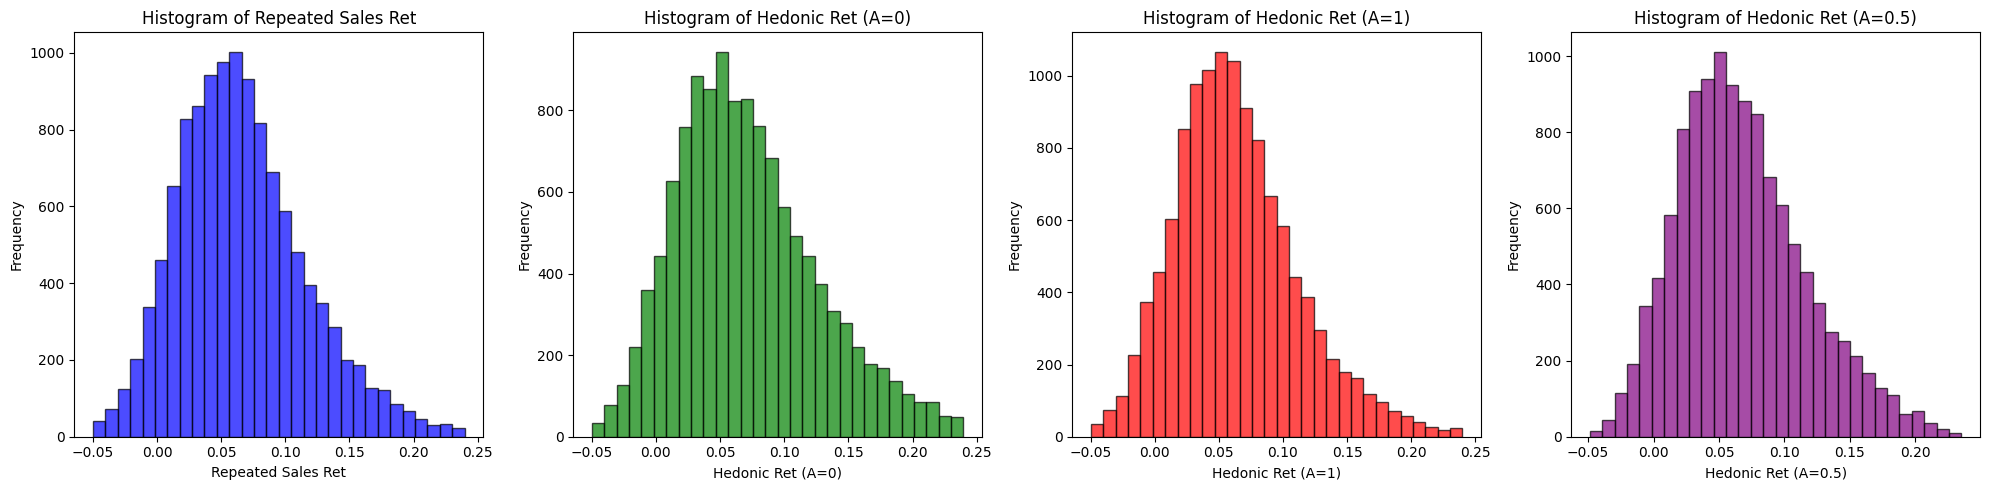

In [46]:
# Further filter for returns between -0.05 and 0.24, including A=0.5
filtered_four_values_ret = filtered_returns_df[
    (filtered_returns_df['repeated_appraisal_return'] >= -0.05) & (filtered_returns_df['repeated_appraisal_return'] <= 0.24) &
    (filtered_returns_df['hedonic_ret_A=0'] >= -0.05) & (filtered_returns_df['hedonic_ret_A=0'] <= 0.24) &
    (filtered_returns_df['hedonic_ret_A=1'] >= -0.05) & (filtered_returns_df['hedonic_ret_A=1'] <= 0.24) &
    (filtered_returns_df['hedonic_ret_A=0.5'] >= -0.05) & (filtered_returns_df['hedonic_ret_A=0.5'] <= 0.24)
]

# Rename columns for clarity
filtered_four_values_ret.rename(columns={
    'repeated_appraisal_return': 'Repeated Sales Ret',
    'hedonic_ret_A=0': 'Hedonic Ret (A=0)',
    'hedonic_ret_A=1': 'Hedonic Ret (A=1)',
    'hedonic_ret_A=0.5': 'Hedonic Ret (A=0.5)'
}, inplace=True)

# Define return columns to plot and corresponding colors
return_columns = ['Repeated Sales Ret', 'Hedonic Ret (A=0)', 'Hedonic Ret (A=1)', 'Hedonic Ret (A=0.5)']
colors = ['blue', 'green', 'red', 'purple']

# Plot histograms for filtered return values
plt.figure(figsize=(20, 5))
for i, (col, color) in enumerate(zip(return_columns, colors), 1):
    plt.subplot(1, 4, i)
    plt.hist(filtered_four_values_ret[col], bins=30, color=color, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

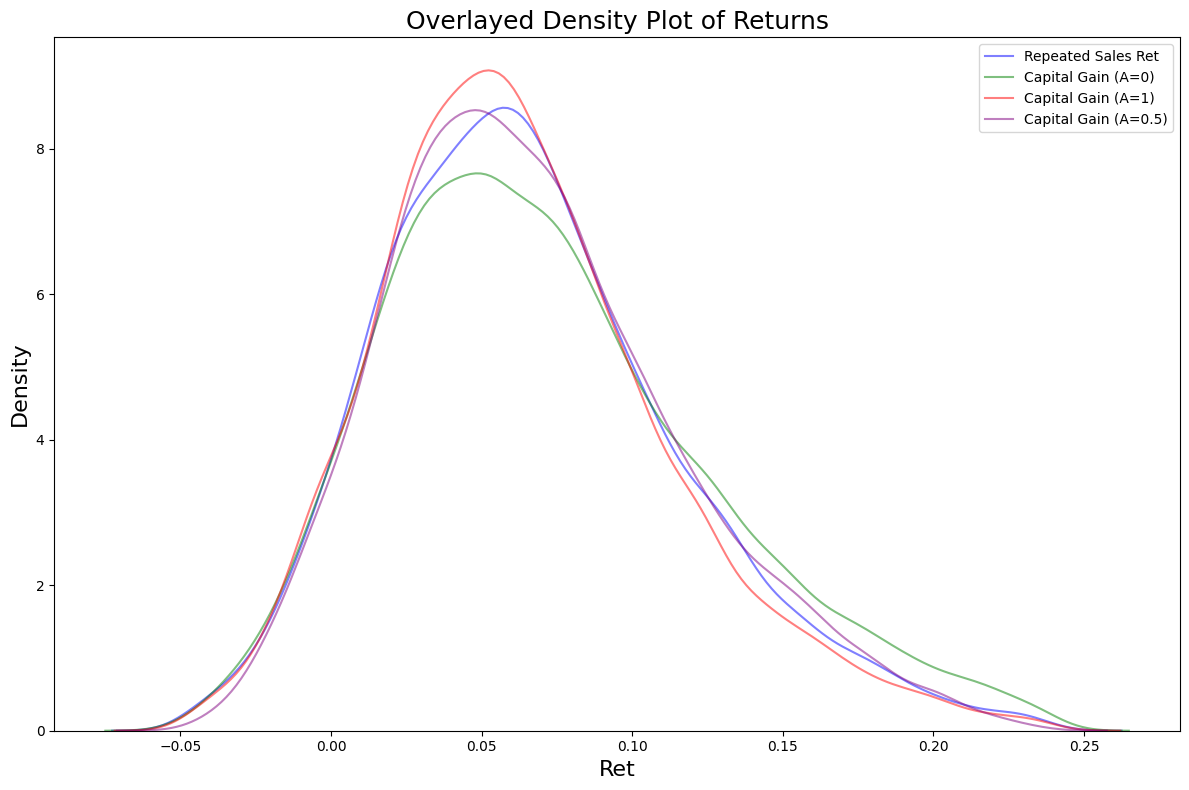

In [47]:
# Plot overlayed density plots for the four return columns with adjusted labels
plt.figure(figsize=(12, 8))

# Overlay the density plots
sns.kdeplot(filtered_four_values_ret['Repeated Sales Ret'], color='blue', label='Repeated Sales Ret', fill=False, alpha=0.5)
sns.kdeplot(filtered_four_values_ret['Hedonic Ret (A=0)'], color='green', label='Capital Gain (A=0)', fill=False, alpha=0.5)
sns.kdeplot(filtered_four_values_ret['Hedonic Ret (A=1)'], color='red', label='Capital Gain (A=1)', fill=False, alpha=0.5)
sns.kdeplot(filtered_four_values_ret['Hedonic Ret (A=0.5)'], color='purple', label='Capital Gain (A=0.5)', fill=False, alpha=0.5)

# Add labels, title, and legend
plt.xlabel('Ret', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Overlayed Density Plot of Returns', fontsize=18)
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

# NOTE: Figure 9: Comparing Capital Gain Return Distributions   Hist_cap_gain_overlay.png

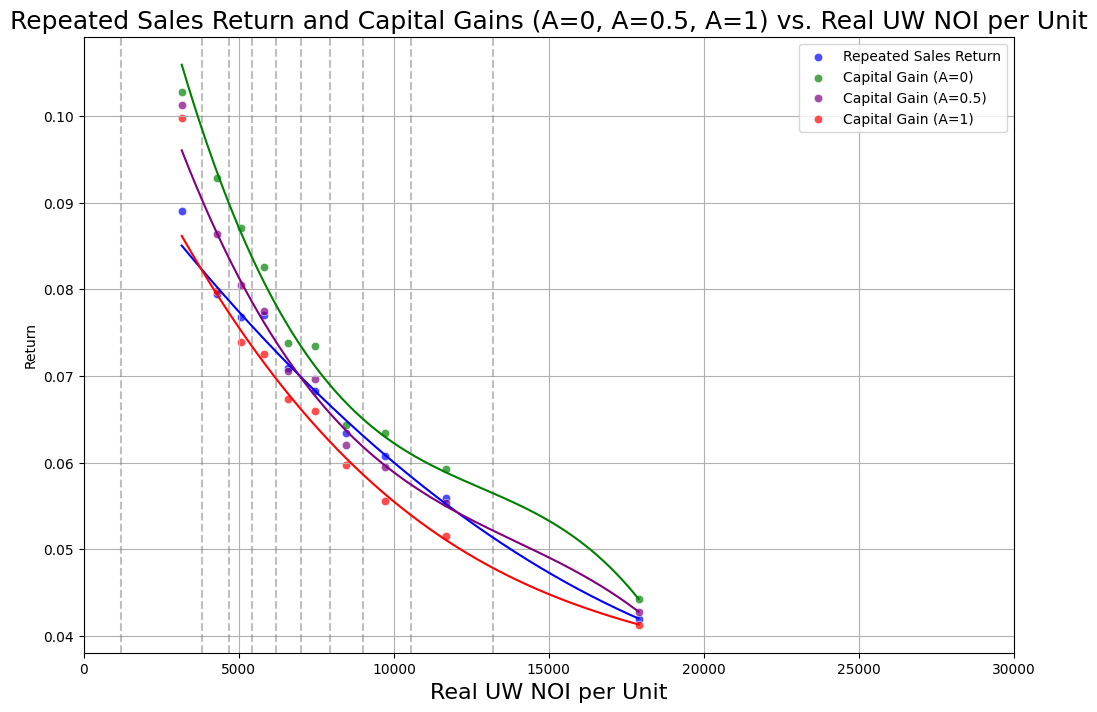

In [48]:
# Copy the dataframe to avoid modifying the original
filtered_df = filtered_returns_df.copy()

# Function to plot the binned scatter plot for repeated appraisal return and capital gain returns (A=0, A=0.5, A=1)
def plot_binned_scatter_combined(data, bin_variable='second_real_uw_noi_per_size', num_bins=10):
    # Create bins for the specified variable (default is second_real_uw_noi_per_size) using qcut for equal-sized bins
    data['NOI_Bin'], bin_edges = pd.qcut(data[bin_variable], q=num_bins, retbins=True, duplicates='drop')
    
    # Calculate the mean of the bin variable and returns for each bin
    binned_data = data.groupby('NOI_Bin').agg({
        bin_variable: 'mean',
        'repeated_appraisal_return': 'mean',
        'hedonic_ret_A=0': 'mean',
        'hedonic_ret_A=0.5': 'mean',
        'hedonic_ret_A=1': 'mean'
    }).reset_index().rename(columns={bin_variable: 'mean_noi'})

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot vertical lines indicating bins
    for edge in bin_edges:
        plt.axvline(edge, color='grey', linestyle='--', alpha=0.5)
        
    # Plot data points for repeated appraisal return
    sns.scatterplot(
        data=binned_data,
        x='mean_noi',
        y='repeated_appraisal_return',
        ax=ax,
        alpha=0.7,
        label='Repeated Sales Return',
        color='blue'
    )

    # Plot data points for capital gain (A=0)
    sns.scatterplot(
        data=binned_data,
        x='mean_noi',
        y='hedonic_ret_A=0',
        ax=ax,
        alpha=0.7,
        label='Capital Gain (A=0)',
        color='green'
    )

    # Plot data points for capital gain (A=0.5)
    sns.scatterplot(
        data=binned_data,
        x='mean_noi',
        y='hedonic_ret_A=0.5',
        ax=ax,
        alpha=0.7,
        label='Capital Gain (A=0.5)',
        color='purple'
    )

    # Plot data points for capital gain (A=1)
    sns.scatterplot(
        data=binned_data,
        x='mean_noi',
        y='hedonic_ret_A=1',
        ax=ax,
        alpha=0.7,
        label='Capital Gain (A=1)',
        color='red'
    )

    # Fit splines through the binned data points
    for ret_col, color in zip(['repeated_appraisal_return', 'hedonic_ret_A=0', 'hedonic_ret_A=0.5', 'hedonic_ret_A=1'], 
                              ['blue', 'green', 'purple', 'red']):
        spline = UnivariateSpline(binned_data['mean_noi'][1:], binned_data[ret_col][1:], s=1)
        x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
        y_spline = spline(x_spline)
        ax.plot(x_spline, y_spline, color=color)

    ax.set_xlim(0, 30000)
    # Add labels and title
    ax.set_xlabel('Real UW NOI per Unit', fontsize=16)
    ax.set_ylabel('Return', color='black')
    ax.tick_params(axis='y', labelcolor='black')
    plt.title('Repeated Sales Return and Capital Gains (A=0, A=0.5, A=1) vs. Real UW NOI per Unit', fontsize=18)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot the combined binned scatter plot, using first_real_uw_noi_per_size as the variable
plot_binned_scatter_combined(filtered_df, bin_variable='first_real_uw_noi_per_size')


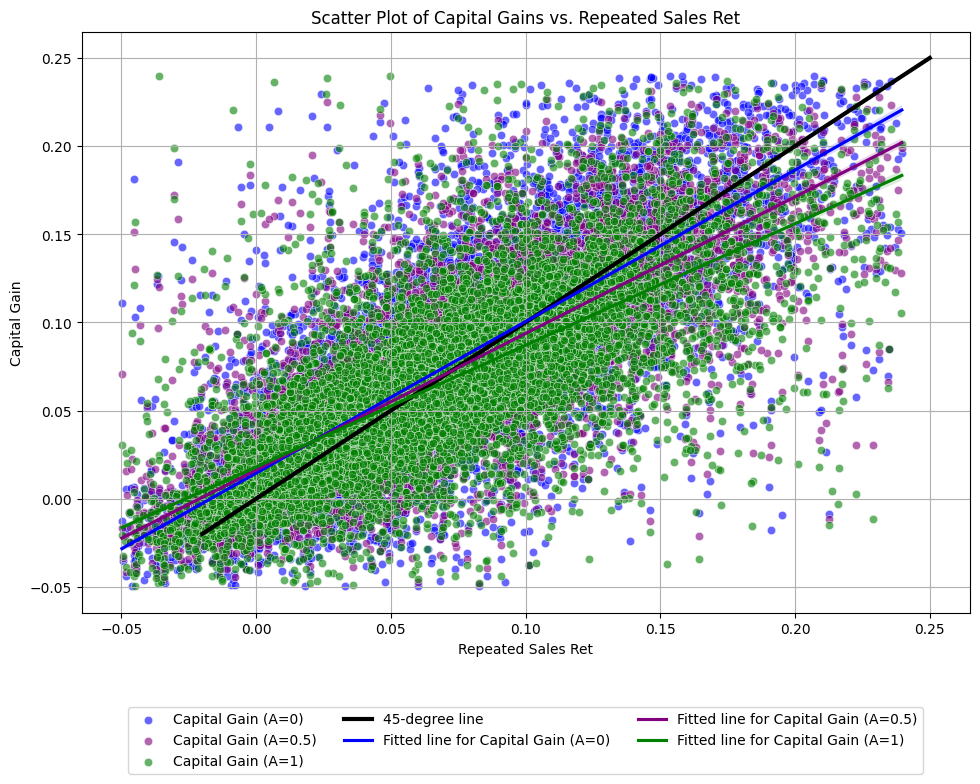

In [49]:
# Initialize the plot
plt.figure(figsize=(10, 8))

# Scatter plot for Capital Gain (A=0)
sns.scatterplot(
    x='Repeated Sales Ret', 
    y='Hedonic Ret (A=0)', 
    data=filtered_four_values_ret, 
    alpha=0.6, 
    color='blue', 
    label='Capital Gain (A=0)'
)

# Scatter plot for Capital Gain (A=0.5)
sns.scatterplot(
    x='Repeated Sales Ret', 
    y='Hedonic Ret (A=0.5)', 
    data=filtered_four_values_ret, 
    alpha=0.6, 
    color='purple', 
    label='Capital Gain (A=0.5)'
)

# Scatter plot for Capital Gain (A=1)
sns.scatterplot(
    x='Repeated Sales Ret', 
    y='Hedonic Ret (A=1)', 
    data=filtered_four_values_ret, 
    alpha=0.6, 
    color='green', 
    label='Capital Gain (A=1)'
)

# Add a 45-degree line
plt.plot([-0.02, 0.25], [-0.02, 0.25], color='black', linestyle='-', linewidth=3, label='45-degree line')

# Fit a regression line for Capital Gain (A=0)
sns.regplot(
    x='Repeated Sales Ret', 
    y='Hedonic Ret (A=0)', 
    data=filtered_four_values_ret, 
    scatter=False, 
    color='blue', 
    label='Fitted line for Capital Gain (A=0)'
)

# Fit a regression line for Capital Gain (A=0.5)
sns.regplot(
    x='Repeated Sales Ret', 
    y='Hedonic Ret (A=0.5)', 
    data=filtered_four_values_ret, 
    scatter=False, 
    color='purple', 
    label='Fitted line for Capital Gain (A=0.5)'
)

# Fit a regression line for Capital Gain (A=1)
sns.regplot(
    x='Repeated Sales Ret', 
    y='Hedonic Ret (A=1)', 
    data=filtered_four_values_ret, 
    scatter=False, 
    color='green', 
    label='Fitted line for Capital Gain (A=1)'
)

# Add labels and title
plt.xlabel('Repeated Sales Ret')
plt.ylabel('Capital Gain')
plt.title('Scatter Plot of Capital Gains vs. Repeated Sales Ret')
plt.grid(True)

# Add legend at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Show the plot
plt.tight_layout()
plt.show()

# NOTE: Figure 10: Scatter Plot Capital Gain Returns: Repeat-Sales vs. Hedonic     Comp_rep_pred.png